<a href="https://colab.research.google.com/github/FatemaSamir/Time-Series-Projects/blob/main/Energy_Consumption_Forecast_ensembling_SARIMAX_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name : Energy Consumption Forecast 
Data set used : 
[Energy Consumption Data](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather) Time series data


---
**Models aplied**


*   SARIMAX
*   LSTM (Vanilla,)

***Hybird Models***
*   SARIMAX + LSTM (ensembling)






In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# Apply Auto Arima 
# from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import warnings
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
# Read Data 
data_weather = pd.read_csv(
    '/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv', 
    parse_dates=['dt_iso']
)

data_energy = pd.read_csv(
    '/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv', 
    parse_dates=['time']
)

In [ ]:
print("shape of energy dataset:",data_energy.shape)
print("shape of weather features dataset:",data_weather.shape)

shape of energy dataset: (35064, 29)
shape of weather features dataset: (178396, 17)


In [ ]:
data_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [ ]:
#seeing null values 
data_energy.isnull().sum()
# (data_energy.isnull().sum()/data_energy.shape[0])*100

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [ ]:
data_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [ ]:
data_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [ ]:
data_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [ ]:
#seeing null values 
data_weather.isnull().sum()
# (data_energy.isnull().sum()/data_energy.shape[0])*100

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [ ]:
data_energy.describe().T


count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

In [ ]:
data_weather.describe().T

count         mean          std     min          25%      50%  \
temp        178396.0   289.618605     8.026199  262.24   283.670000   289.15   
temp_min    178396.0   288.330442     7.955491  262.24   282.483602   288.15   
temp_max    178396.0   291.091267     8.612454  262.24   284.650000   290.15   
pressure    178396.0  1069.260740  5969.631893    0.00  1013.000000  1018.00   
humidity    178396.0    68.423457    21.902888    0.00    53.000000    72.00   
wind_speed  178396.0     2.470560     2.095910    0.00     1.000000     2.00   
wind_deg    178396.0   166.591190   116.611927    0.00    55.000000   177.00   
rain_1h     178396.0     0.075492     0.398847    0.00     0.000000     0.00   
rain_3h     178396.0     0.000380     0.007288    0.00     0.000000     0.00   
snow_3h     178396.0     0.004763     0.222604    0.00     0.000000     0.00   
clouds_all  178396.0    25.073292    30.774129    0.00     0.000000    20.00   
weather_id  178396.0   759.831902   108.733223  200.00   800.000000   800.00   

                    75%          max  
temp         295.150000      315.600  
temp_min     293.730125      315.150  
temp_max     297.150000      321.150  
pressure    1022.000000  1008371.000  
humidity      87.000000      100.000  
wind_speed     4.000000      133.000  
wind_deg     270.000000      360.000  
rain_1h        0.000000       12.000  
rain_3h        0.000000        2.315  
snow_3h        0.000000       21.500  
clouds_all    40.000000      100.000  
weather_id   801.000000      804.000

In [ ]:
#veryfing the type of date cols 
from datetime import datetime
print("Is dt_iso instnace of datetime.datetime?",data_weather.dt_iso.map(lambda x: isinstance(x,datetime)).all())
print("Is time instnace of datetime.datetime?",data_energy.time.map(lambda x: isinstance(x,datetime)).all())


Is dt_iso instnace of datetime.datetime? True
Is time instnace of datetime.datetime? True


# Basic VISULIZATION

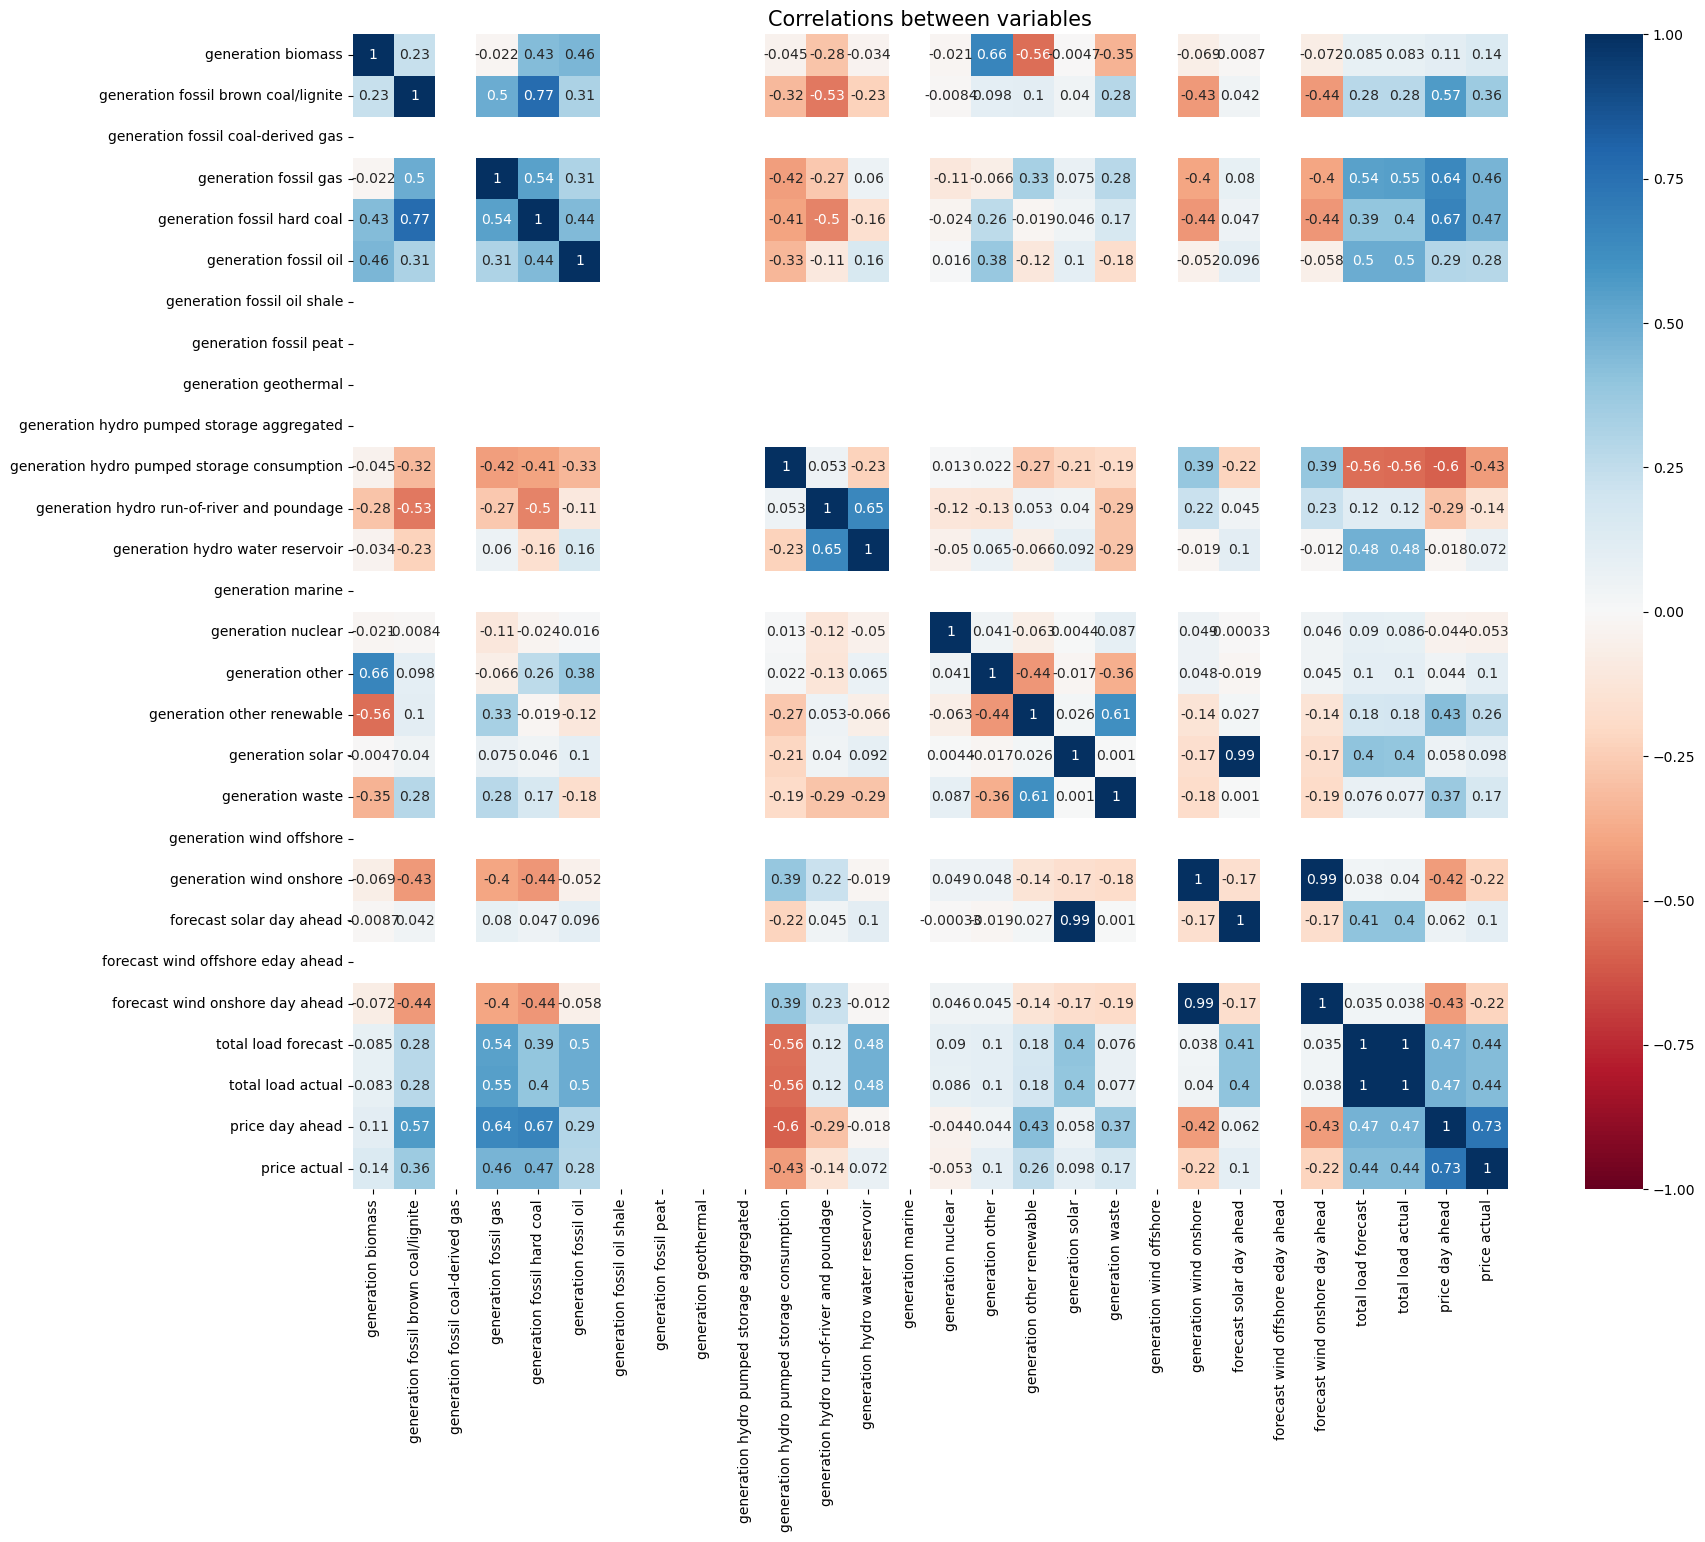

In [ ]:
plt.figure(figsize = (20,15))
sns.heatmap(data_energy.corr(),annot = True,square=True,
            cmap='RdBu',
            vmax=1,
            vmin=-1)
plt.title("Correlations between variables", size = 15)
plt.show()

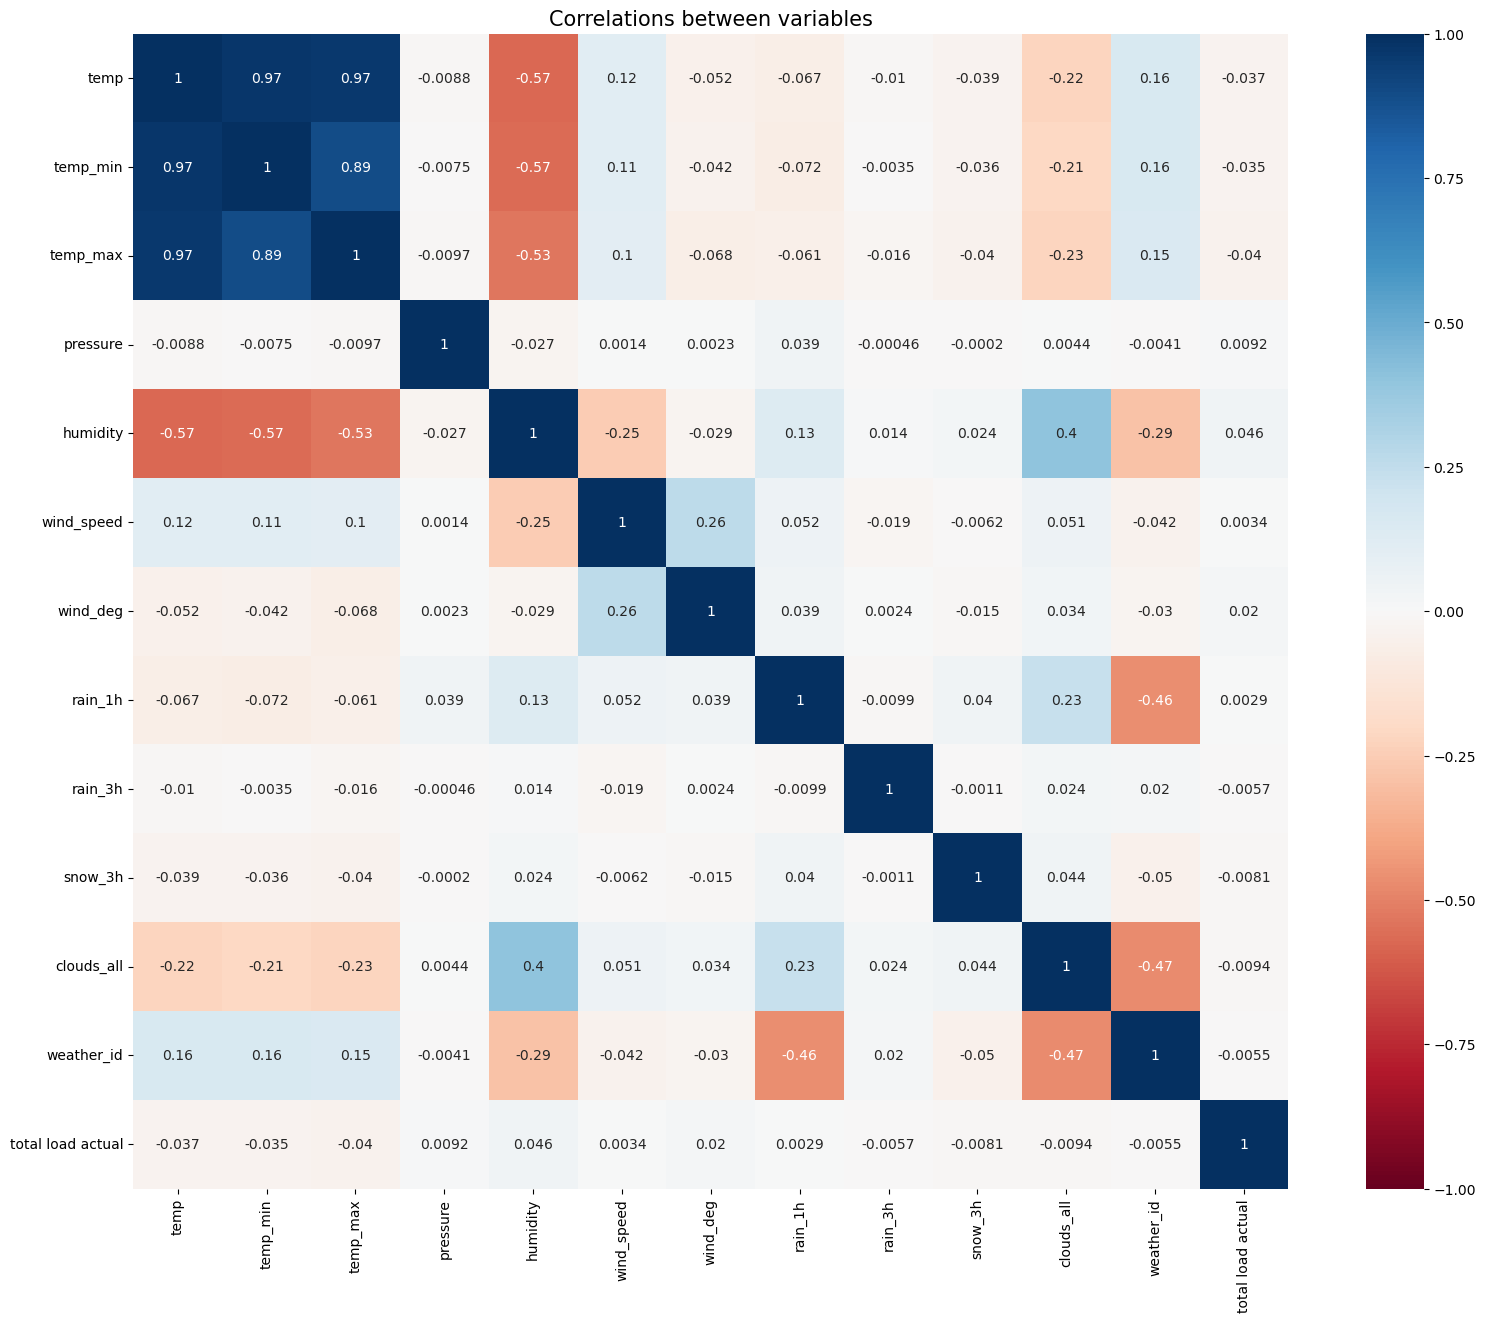

In [ ]:
dw = data_weather.copy()
dw['total load actual'] = data_energy['total load actual']
plt.figure(figsize = (20,15))
sns.heatmap(dw.corr(),annot = True,square=True,
            cmap='RdBu',
            vmax=1,
            vmin=-1)
plt.title("Correlations between variables", size = 15)
plt.show()

# **Pre processing the data**

# 1. Remove colms with std equal zero & not nedded

In [ ]:
#creating dataset
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
def create_dataframe(dataset,date_cols=[],rename_columns=False,
                   remove_cols=False,cols_to_remove=[],
                   datecol_to_group=None,break_time_cols=False,agg_func="mean",
                   change_to_cat=False,cols_to_cat=[]):
    
    new_dataset = dataset.copy()
    #change col to categorical applying one hot encode for categorical cols
    if change_to_cat:
        ohe = OneHotEncoder().fit(new_dataset.loc[:,cols_to_cat])
        for col in cols_to_cat:
            new_dataset[f"{col}"] = pd.Categorical(new_dataset[f"{col}"])
        new_cat_cols = [f"is_{c}" for c in ohe.categories_[0]]
        new_dataset.loc[:,new_cat_cols] = ohe.transform(new_dataset.loc[:,cols_to_cat]).toarray()
    #remove cols
    if remove_cols:
        new_dataset = new_dataset.drop(labels=cols_to_remove,axis=1)
    #convert the date columns to timestamp and create a new column just for date
    if len(date_cols)>0:
        for col in date_cols:
            new_dataset[f"{col}_date"] = [datetime.fromisoformat(str(d)).date() for d in new_dataset[f"{col}"]]
    #break the date by year,month and day
    if break_time_cols:
        for col in date_cols:
            new_dataset[f"{col}_year"] = [d.year for d in new_dataset[f"{col}_date"]]
            new_dataset[f"{col}_month"] = [d.month for d in new_dataset[f"{col}_date"]]
            new_dataset[f"{col}_day"] = [d.day for d in new_dataset[f"{col}_date"]]
    #remove blank spaces in columns and replace by "_"
    if rename_columns:
        new_c = {c:c.replace(" ","_") for c in new_dataset.columns.to_list()}
        new_dataset = new_dataset.rename(new_c,axis="columns")
    
    #create dataset with timestamp index
    new_dataframe = new_dataset.groupby([f"{datecol_to_group}_date"]).agg(agg_func)
    #rename index col
    if new_dataframe.index.name != "datetime":
        new_dataframe.index = new_dataframe.index.rename("datetime")
    
    
    return new_dataframe
    

In [ ]:
rm_cols_enrg = ["forecast solar day ahead","forecast wind offshore eday ahead","forecast wind onshore day ahead",
                "total load forecast","price day ahead","price actual",
                "generation fossil coal-derived gas","generation fossil oil shale","generation fossil peat",
                "generation geothermal","generation marine","generation hydro pumped storage aggregated","generation wind offshore"]
rm_cols_wth = ["city_name","weather_id", "weather_description","weather_icon"]
df_enrg = create_dataframe(data_energy,date_cols=["time"],rename_columns=True,
                             datecol_to_group="time",remove_cols=True,cols_to_remove=rm_cols_enrg,break_time_cols=False)

df_wth = create_dataframe(data_weather,date_cols=["dt_iso"],remove_cols=True,cols_to_remove=rm_cols_wth,
                         datecol_to_group="dt_iso",break_time_cols=False,change_to_cat=True,cols_to_cat=["weather_main"])

print("shape of energy dataset:",df_enrg.shape)
print("shape of weather features dataset:",df_wth.shape)

shape of energy dataset: (1461, 15)
shape of weather features dataset: (1461, 23)


In [ ]:
df_enrg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 2015-01-01 to 2018-12-31
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           1461 non-null   float64
 1   generation_fossil_brown_coal/lignite         1461 non-null   float64
 2   generation_fossil_gas                        1461 non-null   float64
 3   generation_fossil_hard_coal                  1461 non-null   float64
 4   generation_fossil_oil                        1461 non-null   float64
 5   generation_hydro_pumped_storage_consumption  1461 non-null   float64
 6   generation_hydro_run-of-river_and_poundage   1461 non-null   float64
 7   generation_hydro_water_reservoir             1461 non-null   float64
 8   generation_nuclear                           1461 non-null   float64
 9   generation_other                             1461 non-null   flo

In [ ]:
#visualizing energy dataframe
print("Energy dataset columns:",df_enrg.columns.to_list())
df_enrg.head()


Energy dataset columns: ['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run-of-river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual']


generation_biomass  generation_fossil_brown_coal/lignite  \
datetime                                                               
2015-01-01          428.500000                            257.416667   
2015-01-02          385.291667                              0.000000   
2015-01-03          440.500000                              0.000000   
2015-01-04          397.125000                              0.000000   
2015-01-05          360.764706                             25.294118   

            generation_fossil_gas  generation_fossil_hard_coal  \
datetime                                                         
2015-01-01            4256.750000                  4246.541667   
2015-01-02            3540.666667                  1237.000000   
2015-01-03            3444.291667                  1344.250000   
2015-01-04            3469.583333                  2244.958333   
2015-01-05            4603.294118                  2640.000000   

            generation_fossil_oil  \
datetime                            
2015-01-01             160.208333   
2015-01-02             198.625000   
2015-01-03             226.583333   
2015-01-04             355.416667   
2015-01-05             322.470588   

            generation_hydro_pumped_storage_consumption  \
datetime                                                  
2015-01-01                                  1070.416667   
2015-01-02                                  1543.666667   
2015-01-03                                  1338.458333   
2015-01-04                                   590.000000   
2015-01-05                                  1161.588235   

            generation_hydro_run-of-river_and_poundage  \
datetime                                                 
2015-01-01                                 1047.875000   
2015-01-02                                 1293.541667   
2015-01-03                                 1374.750000   
2015-01-04                                 1495.250000   
2015-01-05                                 1165.529412   

            generation_hydro_water_reservoir  generation_nuclear  \
datetime                                                           
2015-01-01                       2166.875000         7097.000000   
2015-01-02                       3714.958333         7105.833333   
2015-01-03                       3969.416667         7095.375000   
2015-01-04                       3241.333333         7083.625000   
2015-01-05                       2541.529412         3932.176471   

            generation_other  generation_other_renewable  generation_solar  \
datetime                                                                     
2015-01-01         42.250000                   73.958333       1143.458333   
2015-01-02         44.250000                   61.375000       1252.208333   
2015-01-03         78.041667                   66.583333       1119.625000   
2015-01-04         83.708333                   57.458333       2402.500000   
2015-01-05         40.000000                   73.470588       1085.941176   

            generation_waste  generation_wind_onshore  total_load_actual  
datetime                                                                  
2015-01-01        202.166667              3708.416667       23896.750000  
2015-01-02        185.250000             11225.375000       27251.291667  
2015-01-03        203.958333              9167.416667       25110.666667  
2015-01-04        159.291667              8065.666667       27112.625000  
2015-01-05        151.529412              7327.705882       22559.444444

In [ ]:
#visualizing weather dataframe
print("Weather dataset columns:",df_wth.columns.to_list())
df_wth.head()

Weather dataset columns: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'is_clear', 'is_clouds', 'is_drizzle', 'is_dust', 'is_fog', 'is_haze', 'is_mist', 'is_rain', 'is_smoke', 'is_snow', 'is_squall', 'is_thunderstorm']


temp    temp_min    temp_max     pressure   humidity  \
datetime                                                                 
2015-01-01  276.928845  276.928845  276.928845  1021.991667  75.391667   
2015-01-02  277.897585  277.897585  277.897585  1024.441667  77.833333   
2015-01-03  278.817864  278.817864  278.817864  1020.741667  78.591667   
2015-01-04  279.630031  279.630031  279.630031  1015.858333  76.766667   
2015-01-05  279.032920  279.032920  279.032920  1014.508333  81.158333   

            wind_speed    wind_deg  rain_1h  rain_3h  snow_3h  ...  \
datetime                                                       ...   
2015-01-01    1.950000  181.600000   0.0000      0.0      0.0  ...   
2015-01-02    1.575000  214.408333   0.0000      0.0      0.0  ...   
2015-01-03    1.575000  191.033333   0.0000      0.0      0.0  ...   
2015-01-04    1.258333  156.408333   0.0425      0.0      0.0  ...   
2015-01-05    1.150000  174.300000   0.0125      0.0      0.0  ...   

            is_drizzle  is_dust  is_fog  is_haze  is_mist   is_rain  is_smoke  \
datetime                                                                        
2015-01-01         0.0      0.0     0.0      0.0      0.0  0.000000       0.0   
2015-01-02         0.0      0.0     0.0      0.0      0.0  0.000000       0.0   
2015-01-03         0.0      0.0     0.0      0.0      0.0  0.000000       0.0   
2015-01-04         0.0      0.0     0.0      0.0      0.0  0.141667       0.0   
2015-01-05         0.0      0.0     0.0      0.0      0.0  0.041667       0.0   

            is_snow  is_squall  is_thunderstorm  
datetime                                         
2015-01-01      0.0        0.0              0.0  
2015-01-02      0.0        0.0              0.0  
2015-01-03      0.0        0.0              0.0  
2015-01-04      0.0        0.0              0.0  
2015-01-05      0.0        0.0              0.0  

[5 rows x 23 columns]

In [ ]:
df_enrg.isnull().sum()

generation_biomass                             0
generation_fossil_brown_coal/lignite           0
generation_fossil_gas                          0
generation_fossil_hard_coal                    0
generation_fossil_oil                          0
generation_hydro_pumped_storage_consumption    0
generation_hydro_run-of-river_and_poundage     0
generation_hydro_water_reservoir               0
generation_nuclear                             0
generation_other                               0
generation_other_renewable                     0
generation_solar                               0
generation_waste                               0
generation_wind_onshore                        0
total_load_actual                              0
dtype: int64

In [ ]:
df_wth.isnull().sum()

temp               0
temp_min           0
temp_max           0
pressure           0
humidity           0
wind_speed         0
wind_deg           0
rain_1h            0
rain_3h            0
snow_3h            0
clouds_all         0
is_clear           0
is_clouds          0
is_drizzle         0
is_dust            0
is_fog             0
is_haze            0
is_mist            0
is_rain            0
is_smoke           0
is_snow            0
is_squall          0
is_thunderstorm    0
dtype: int64

In [ ]:
print("Years for weather data")
all_years_wth = np.array([i_wth.year for i_wth in df_wth.index])
years_wth,count_values_wth = np.unique(all_years_wth,return_counts=True)
for year_wth,count_wth in zip(years_wth,count_values_wth):
    print(f"{year_wth}: {count_wth}")

print("Years for energy data")
all_years_enrg = np.array([i_enrg.year for i_enrg in df_enrg.index])
years_enrg,count_values_enrg = np.unique(all_years_enrg,return_counts=True)
for year_enrg,count_enrg in zip(years_enrg,count_values_enrg):
    print(f"{year_enrg}: {count_enrg}")

Years for weather data
2015: 365
2016: 366
2017: 365
2018: 365
Years for energy data
2015: 365
2016: 366
2017: 365
2018: 365


# **Merge Data**

In [ ]:
# merge All data (weather and energy)
all_data = df_enrg.join(df_wth,on="datetime",how="inner")
print("cols:",all_data.columns.to_list())
all_data.head()

cols: ['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run-of-river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'is_clear', 'is_clouds', 'is_drizzle', 'is_dust', 'is_fog', 'is_haze', 'is_mist', 'is_rain', 'is_smoke', 'is_snow', 'is_squall', 'is_thunderstorm']


generation_biomass  generation_fossil_brown_coal/lignite  \
datetime                                                               
2015-01-01          428.500000                            257.416667   
2015-01-02          385.291667                              0.000000   
2015-01-03          440.500000                              0.000000   
2015-01-04          397.125000                              0.000000   
2015-01-05          360.764706                             25.294118   

            generation_fossil_gas  generation_fossil_hard_coal  \
datetime                                                         
2015-01-01            4256.750000                  4246.541667   
2015-01-02            3540.666667                  1237.000000   
2015-01-03            3444.291667                  1344.250000   
2015-01-04            3469.583333                  2244.958333   
2015-01-05            4603.294118                  2640.000000   

            generation_fossil_oil  \
datetime                            
2015-01-01             160.208333   
2015-01-02             198.625000   
2015-01-03             226.583333   
2015-01-04             355.416667   
2015-01-05             322.470588   

            generation_hydro_pumped_storage_consumption  \
datetime                                                  
2015-01-01                                  1070.416667   
2015-01-02                                  1543.666667   
2015-01-03                                  1338.458333   
2015-01-04                                   590.000000   
2015-01-05                                  1161.588235   

            generation_hydro_run-of-river_and_poundage  \
datetime                                                 
2015-01-01                                 1047.875000   
2015-01-02                                 1293.541667   
2015-01-03                                 1374.750000   
2015-01-04                                 1495.250000   
2015-01-05                                 1165.529412   

            generation_hydro_water_reservoir  generation_nuclear  \
datetime                                                           
2015-01-01                       2166.875000         7097.000000   
2015-01-02                       3714.958333         7105.833333   
2015-01-03                       3969.416667         7095.375000   
2015-01-04                       3241.333333         7083.625000   
2015-01-05                       2541.529412         3932.176471   

            generation_other  ...  is_drizzle  is_dust  is_fog  is_haze  \
datetime                      ...                                         
2015-01-01         42.250000  ...         0.0      0.0     0.0      0.0   
2015-01-02         44.250000  ...         0.0      0.0     0.0      0.0   
2015-01-03         78.041667  ...         0.0      0.0     0.0      0.0   
2015-01-04         83.708333  ...         0.0      0.0     0.0      0.0   
2015-01-05         40.000000  ...         0.0      0.0     0.0      0.0   

            is_mist   is_rain  is_smoke  is_snow  is_squall  is_thunderstorm  
datetime                                                                      
2015-01-01      0.0  0.000000       0.0      0.0        0.0              0.0  
2015-01-02      0.0  0.000000       0.0      0.0        0.0              0.0  
2015-01-03      0.0  0.000000       0.0      0.0        0.0              0.0  
2015-01-04      0.0  0.141667       0.0      0.0        0.0              0.0  
2015-01-05      0.0  0.041667       0.0      0.0        0.0              0.0  

[5 rows x 38 columns]

# **Visulization**

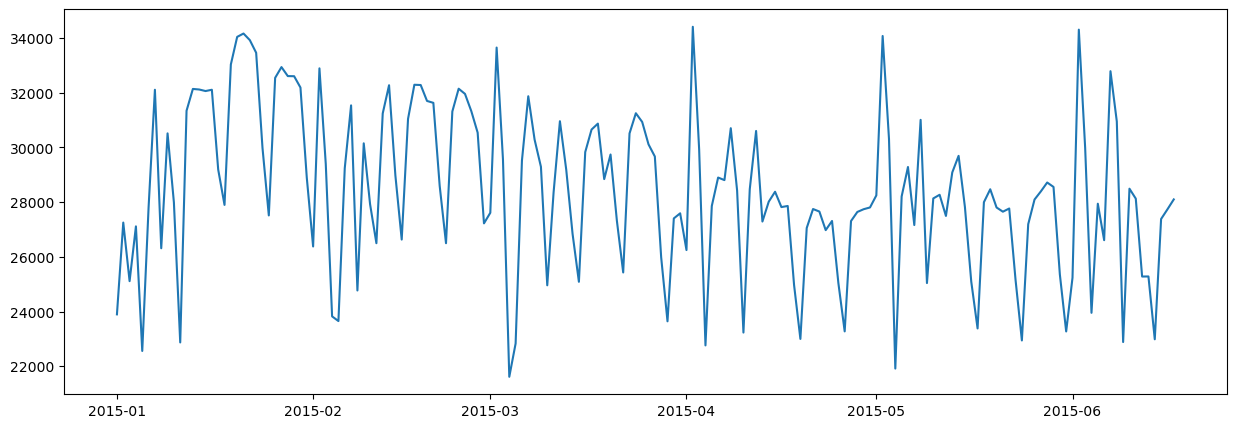

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(df_enrg['total_load_actual'][:24*7*1])

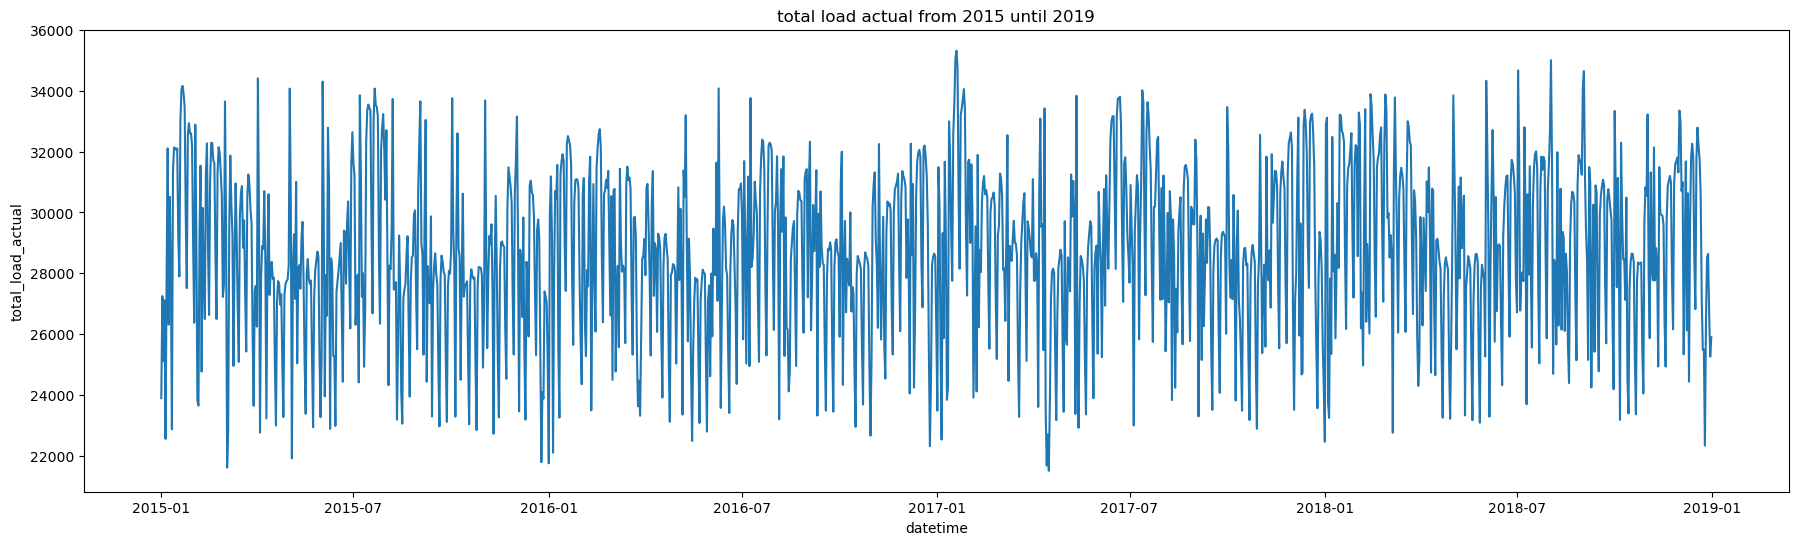

In [ ]:
plt.figure(figsize=(22,6))
sns.lineplot(x=df_enrg.index, y=df_enrg['total_load_actual'])
plt.title('total load actual from 2015 until 2019')
plt.show()

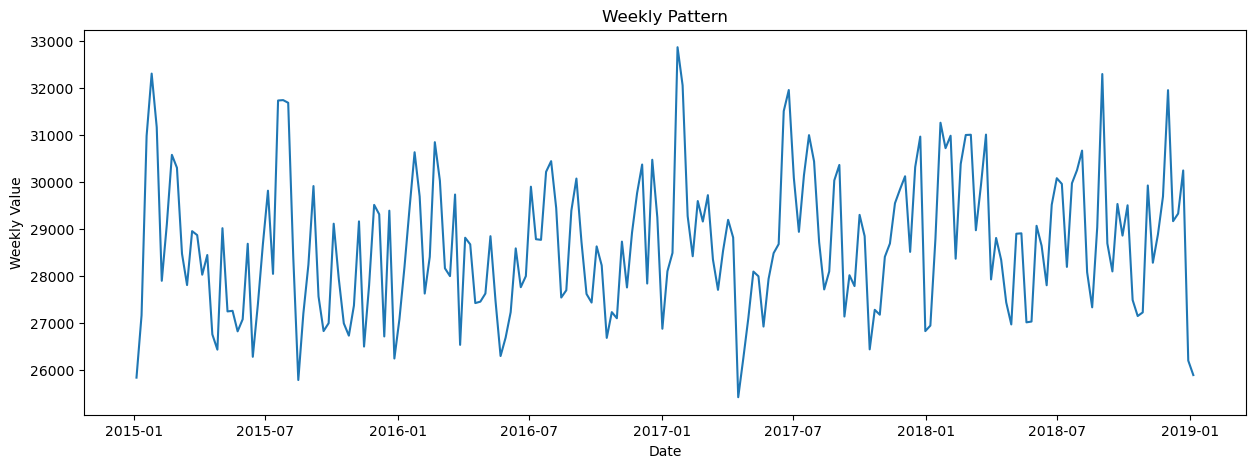

In [ ]:
# Convert the 'date' column to a pandas datetime format (if not already)
data = all_data.copy()
data.index = pd.to_datetime(data.index)
# Set the 'date' column as the index
# data = data.set_index('date')

# Resample the data to weekly frequency (summing or averaging the values)
weekly_data = data.resample('W').mean()  # or .mean() if appropriate

# Plot the weekly data
plt.plot(weekly_data['total_load_actual'])
plt.xlabel('Date')
plt.ylabel('Weekly Value')
plt.title('Weekly Pattern')
plt.show()

<AxesSubplot:xlabel='datetime'>

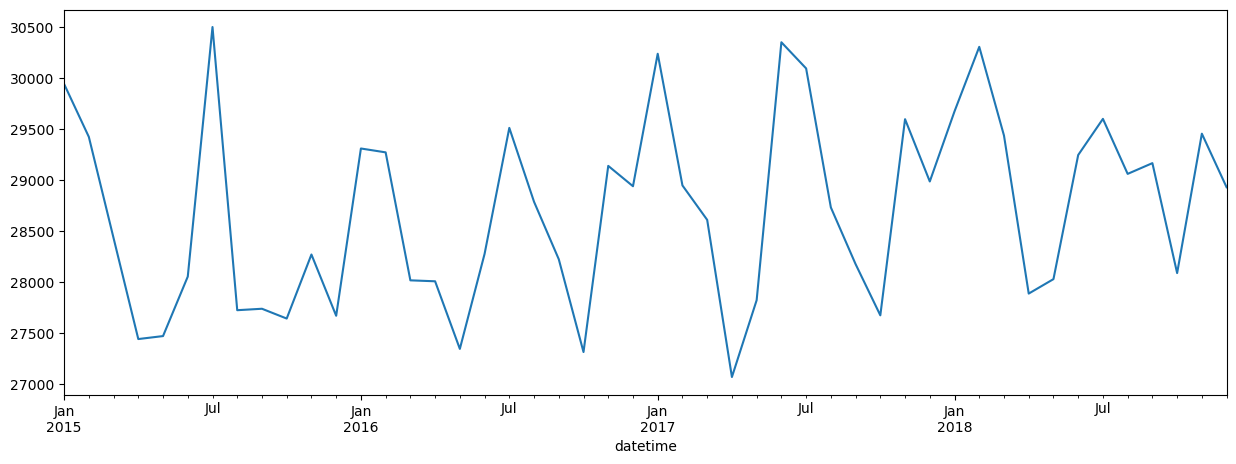

In [ ]:
data['total_load_actual'].resample('M').mean().plot() # there trend

<AxesSubplot:xlabel='datetime'>

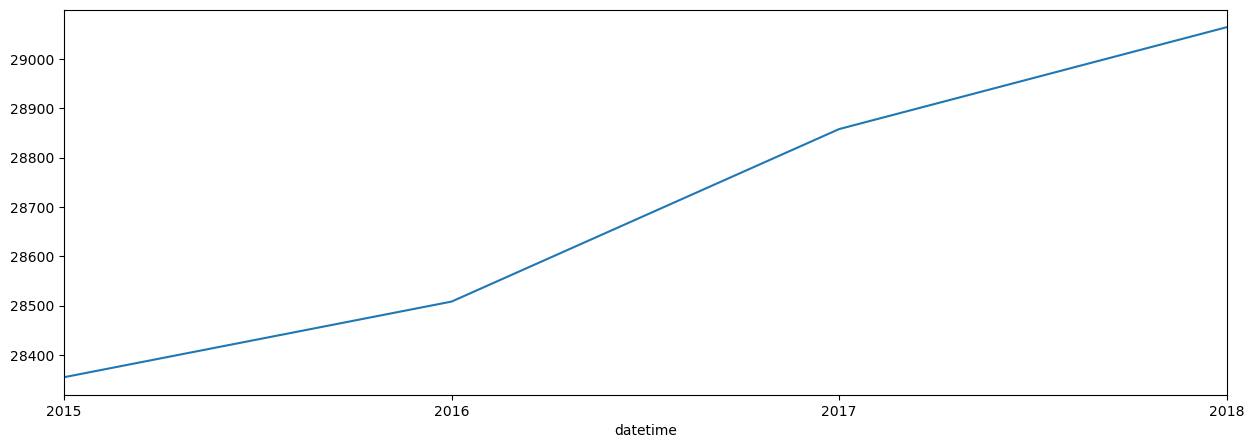

In [ ]:
data['total_load_actual'].resample('Y').mean().plot() # there trend

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


<AxesSubplot:ylabel='Density'>

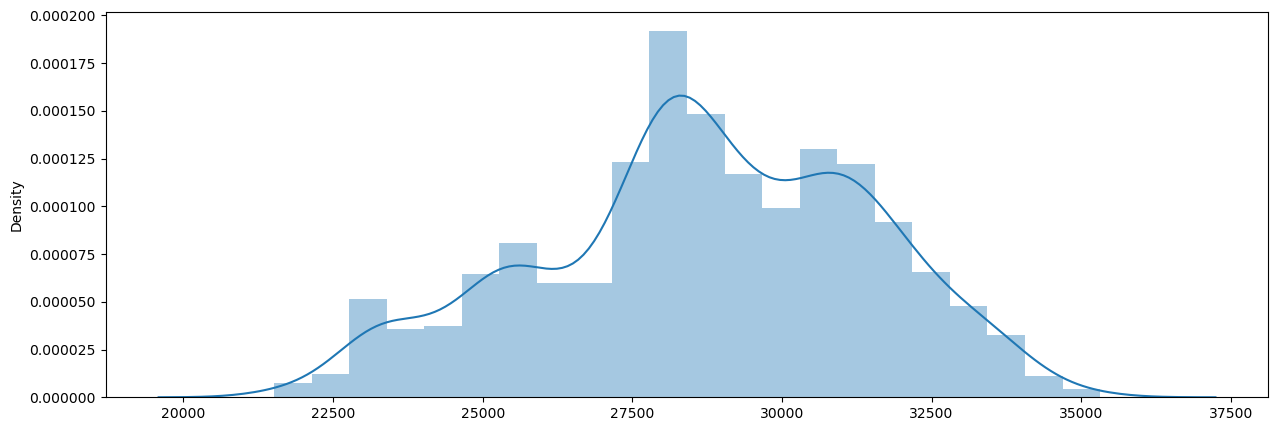

In [ ]:
# Total Generation
sns.distplot(x= all_data['total_load_actual'], kde = True)

Obvously curve-like shape of the Gaussian distribution. "**stationary**" , however let's check it mathmatically

# **Test Stationary**

## Stationarize the data:
What does it mean for data to be stationary?

* The mean of the series should not be a function of time. The red graph below is not stationary because the mean increases over time.
* The variance of the series should not be a function of time. This property is known as homoscedasticity. Notice in the red graph the varying spread of data over time.
* Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’.

need to check stationary
Why is this important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

There are two ways you can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the Dickey-Fuller test. I won’t go into the specifics of this test, but if the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary. Below is code that will help you visualize the time series and test for stationarity.

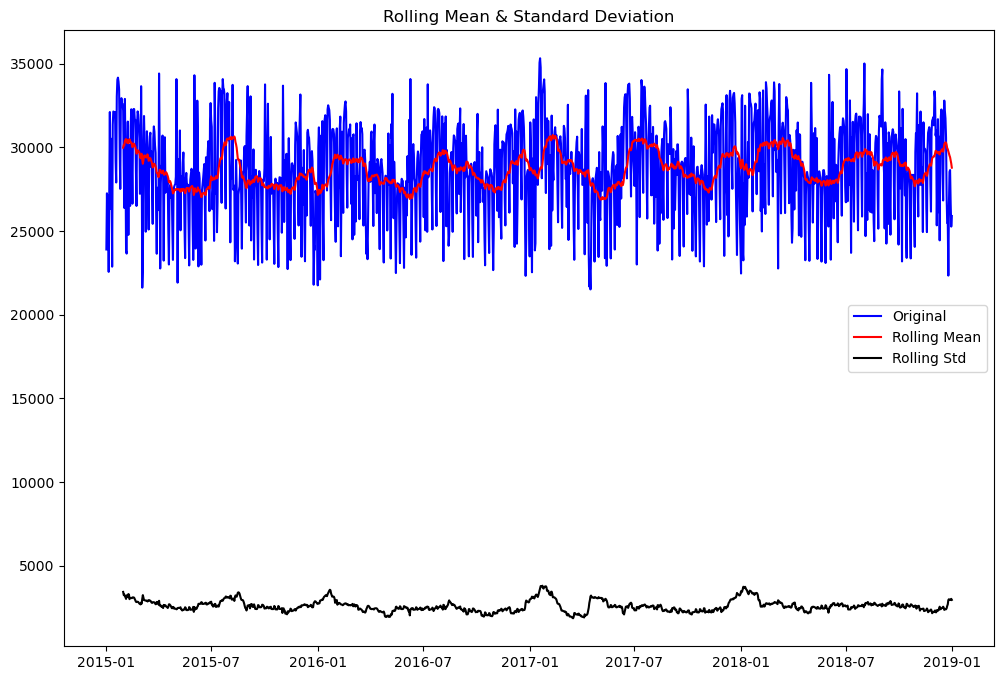

Results of Dickey-Fuller Test:
p-value = 0.00000004. The series is likely stationary.
Test Statistic                -6.255014e+00
p-value                        4.360343e-08
#Lags Used                     2.000000e+01
Number of Observations Used    1.440000e+03
Critical Value (1%)           -3.434899e+00
Critical Value (5%)           -2.863549e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 30, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.8f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.8f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(all_data['total_load_actual'])

### Notice p is 0.00000004 small than 0.05 then the time serise is stetionary

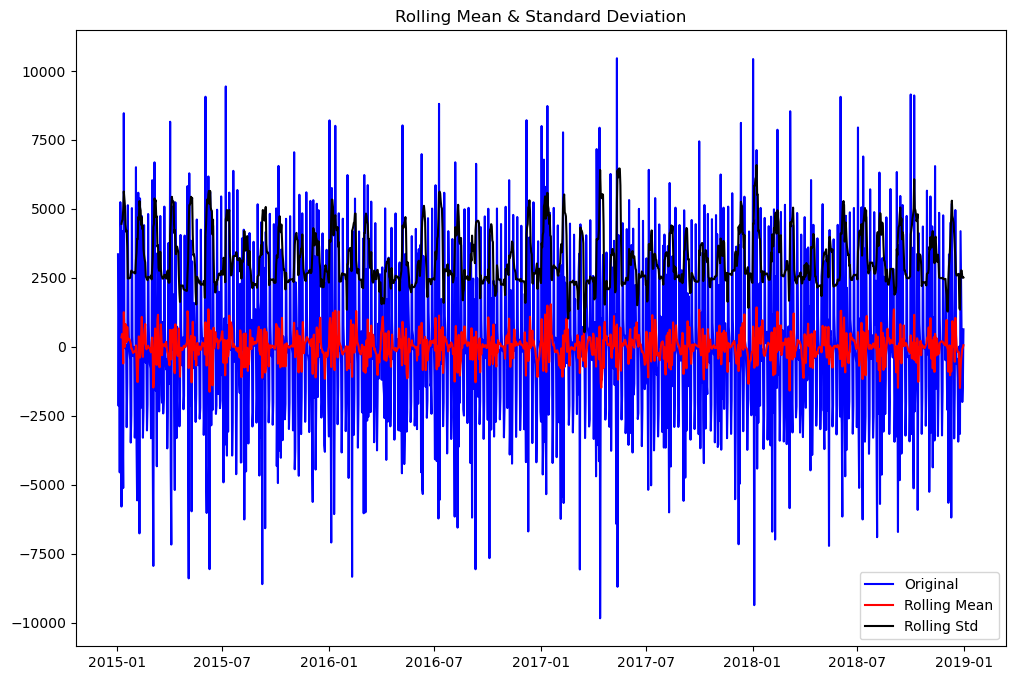

Results of Dickey-Fuller Test:
p-value = 0.00000000. The series is likely stationary.
Test Statistic                -1.488186e+01
p-value                        1.604906e-27
#Lags Used                     1.900000e+01
Number of Observations Used    1.440000e+03
Critical Value (1%)           -3.434899e+00
Critical Value (5%)           -2.863549e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


In [ ]:
first_diff = all_data.total_load_actual - all_data.total_load_actual.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 7)

## Check Seasonality

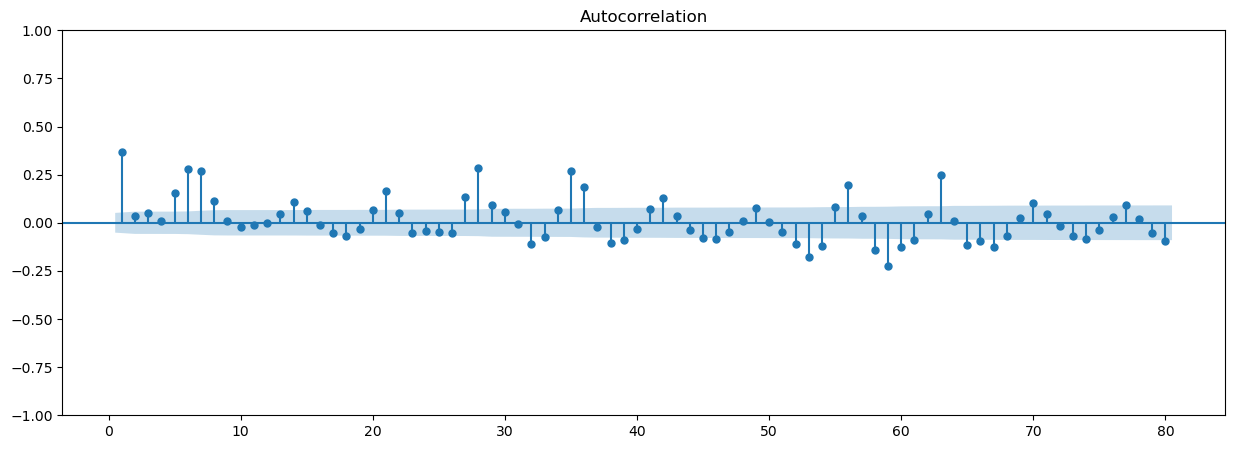

In [ ]:

df_seaon = pd.DataFrame({'total_load_actual':all_data['total_load_actual']} ) 
df_seaon = df_seaon.dropna()
fig, ax1 = plt.subplots()
plot_acf(df_seaon,lags=80,zero=False, ax = ax1)
plt.show()

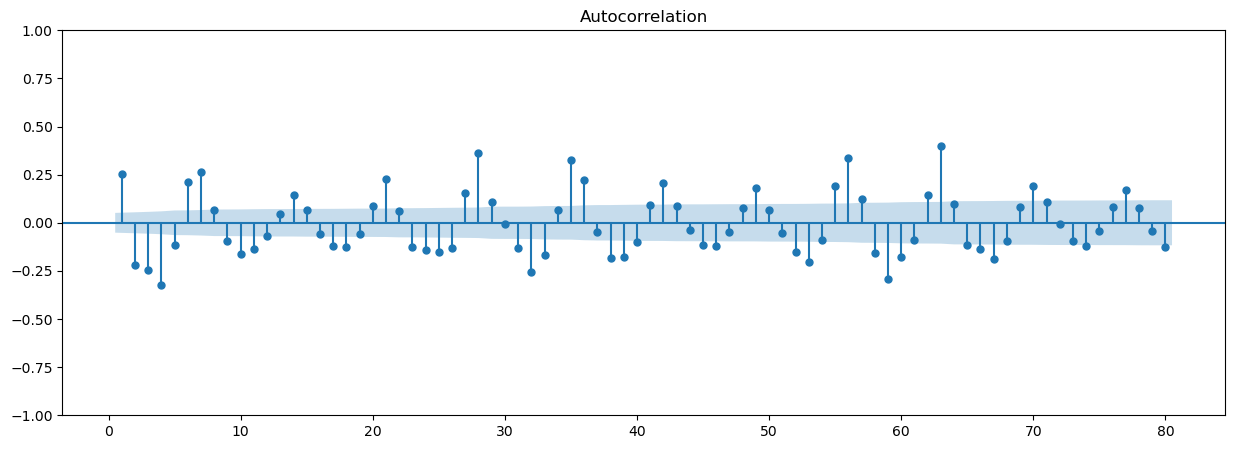

In [ ]:

df_seaon = pd.DataFrame({'total_load_actual':all_data['total_load_actual']-all_data['total_load_actual'].rolling(6).mean()} ) 
df_seaon = df_seaon.dropna()
fig, ax1 = plt.subplots()
plot_acf(df_seaon,lags=80,zero=False, ax = ax1)
plt.show()

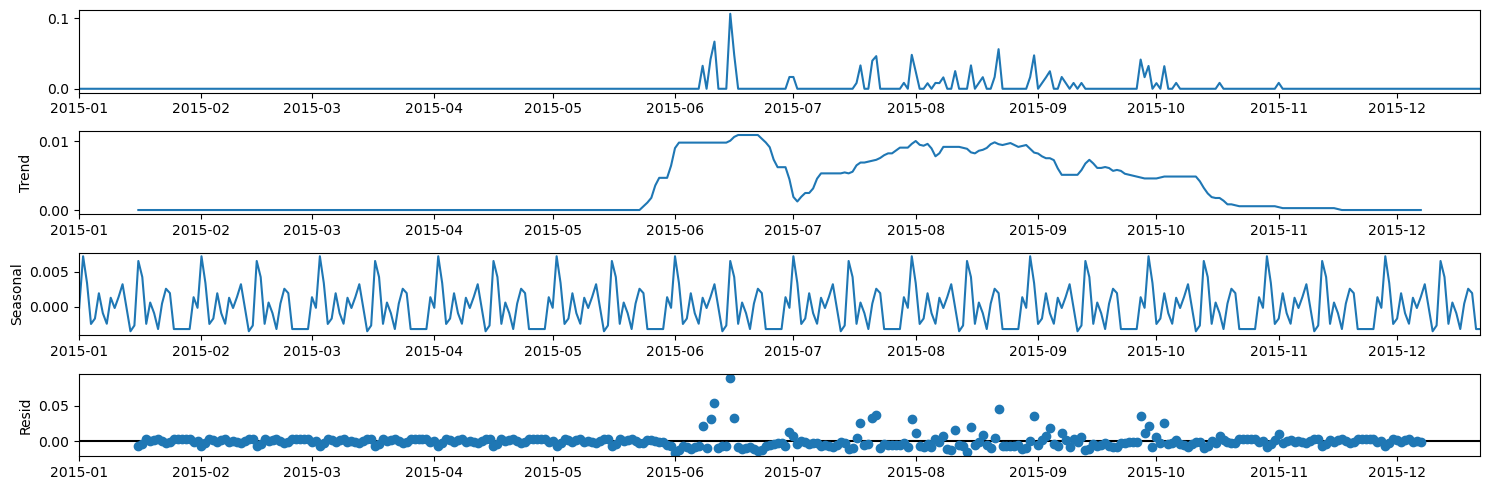

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(all_data.iloc[:356,[-1]],period= 30);
results.plot();   

## obviosly seaonality S is 6 or 7

# *  Spllit All data to train and test data
" our dataset can be divided by 7 (this means that we're going to use all the full weeks from the data)"

So, in the cell below we're going to use 1092 days for training (156 full 7 days weeks) and 364 days for test (52 full 7 days weeks).

In [ ]:
begin_train_date = pd.to_datetime(datetime.strptime("2015-01-01","%Y-%m-%d").date()) 
end_train_date = pd.to_datetime(datetime.strptime("2017-12-29","%Y-%m-%d").date())
end_test_date = pd.to_datetime(datetime.strptime("2018-12-29","%Y-%m-%d").date())


X_train = all_data.loc[(all_data.index > begin_train_date)&(all_data.index < end_train_date),~all_data.columns.isin(["total_load_actual"])]
y_train = all_data.loc[(all_data.index > begin_train_date)&(all_data.index < end_train_date),"total_load_actual"]
X_test = all_data.loc[(all_data.index>end_train_date)&(all_data.index<end_test_date),~all_data.columns.isin(["total_load_actual"])]
y_test =all_data.loc[(all_data.index>end_train_date)&(all_data.index<end_test_date),"total_load_actual"]

print("Number of train data: ", X_train.shape)
print("Number of test data: ",X_test.shape)

Number of train data:  (1092, 37)
Number of test data:  (364, 37)


/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


# **EVALUATIN METHODS**

In [ ]:
from sklearn.metrics import r2_score

def Evaluate(actual, predicted):
    """"
    take 2 data frames Y_test(actual) and Y_predect(forcast)
    and evalaute them using 3 loss functions """
    y_true = actual
    y_pred = predicted
     # Mean Squere Error
    MSE = mean_squared_error(actual,predicted)
    print(f'Mean Squared error : {MSE}'  )
    # Root Mean Squere Error
    rms = np.sqrt(MSE)
    print(f'Root Mean Squere Error : {rms}')
    # R2 
    print(f'r2_score : {r2_score(y_true, y_pred)}')
    # Mean Absolute Error
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
    print('Mean absolute percentage error (MAPE) MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

# **Apply Auto SARIMAX**

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:0000:010:01


# **Adjust m = 6**

In [ ]:
# Apply Auto Arima 
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
col = X_train.columns.values
# Fit the Auto SARIMAX model to the scaled training data
model = auto_arima(y_train, seasonal=True, exogenous = X_train[col],test='adf',error_action='ignore', m = 6,
                           suppress_warnings=True,stepwise=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=inf, Time=5.10 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=20399.669, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=20205.959, Time=1.46 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=20178.944, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=25520.256, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[6] intercept   : AIC=20209.288, Time=0.17 sec
 ARIMA(0,0,1)(1,0,1)[6] intercept   : AIC=20180.914, Time=2.32 sec
 ARIMA(0,0,1)(0,0,2)[6] intercept   : AIC=20180.901, Time=0.73 sec
 ARIMA(0,0,1)(1,0,0)[6] intercept   : AIC=20210.418, Time=0.89 sec
 ARIMA(0,0,1)(1,0,2)[6] intercept   : AIC=20183.200, Time=5.57 sec
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=20305.149, Time=0.63 sec
 ARIMA(1,0,1)(0,0,1)[6] intercept   : AIC=20192.641, Time=0.69 sec
 ARIMA(0,0,2)(0,0,1)[6] intercept   : AIC=20177.130, Time=0.54 sec
 ARIMA(0,0,2)(0,0,0)[6] intercept   : AIC=20209.322, Time=0.26 sec
 ARIMA(0,0,2)(1,0,1)[6] i

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1092
Model:               SARIMAX(5, 0, 4)   Log Likelihood              -10044.497
Date:                Fri, 19 May 2023   AIC                          20110.995
Time:                        21:20:15   BIC                          20165.948
Sample:                    01-02-2015   HQIC                         20131.792
                         - 12-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.163e+04   4071.382      2.857      0.004    3652.694    1.96e+04
ar.L1          1.1384      0.168      6.778      0.000       0.809       1.468
ar.L2         -0.3687      0.152     -2.427      0.0

Mean Squared error : 11369326.356039662
Root Mean Squere Error : 3371.8431689566555
r2_score : -0.5125629150233357
Mean absolute percentage error (MAPE) MAPE: 8.66 % 
SMAPE: 8.73 %


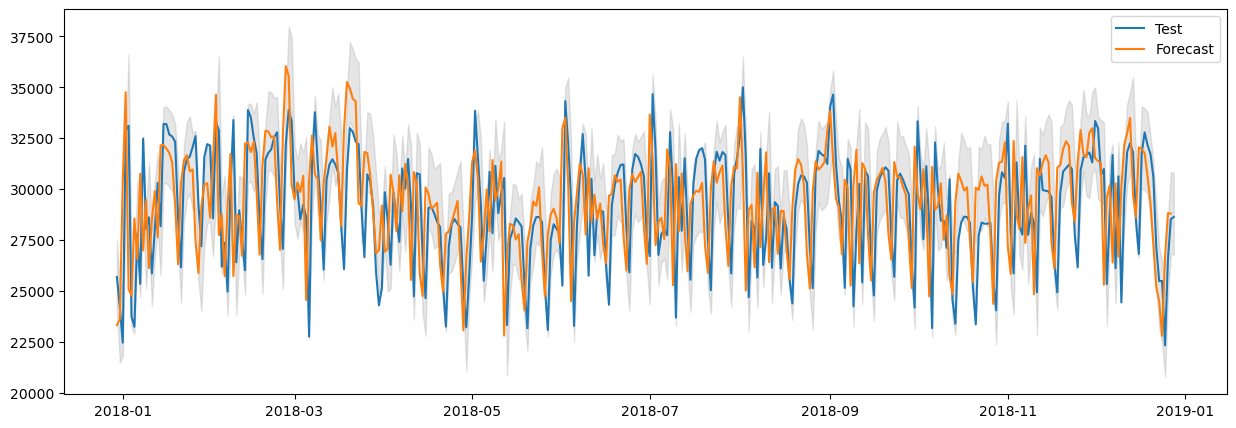

In [ ]:
model.fit(X=X_train, y = y_train)
# Obtain the forecasted values
forecast, conf_int = model.predict(X=X_test, n_periods=len(y_test),return_conf_int=True)

# Create a DataFrame with the forecasted values
forecast_df = pd.DataFrame({'forecast': forecast,'lower_bound': conf_int[:, 0], 'upper_bound': conf_int[:, 1]}, index=X_test.index)

# Calculate lower and upper bounds (replace with appropriate calculation)
# lower_bound = forecast - 1.0
# upper_bound = forecast + 1.0

# Evaluate the model's performance (e.g., using metrics like RMSE or MAE)
Evaluate(y_test,forecast_df['forecast'].fillna(0))

# Plot the forecasted values and the actual values

# plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(forecast_df['forecast'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['lower_bound'], forecast_df['upper_bound'], color='gray', alpha=0.2)
plt.legend()
plt.show()

# **Adjust m = 7**

In [ ]:
# Apply Auto Arima 
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
# col = X_train.columns.values
col = X_train.columns.values

# Fit the Auto SARIMAX model to the scaled training data
model = auto_arima(y_train, seasonal=True, exogenous = X_train[col],test='adf',error_action='ignore', m =7,
                           suppress_warnings=True,stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=20130.247, Time=5.76 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=20399.669, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=20206.441, Time=1.32 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=20177.445, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=25520.256, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=20162.987, Time=2.45 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=20398.184, Time=5.87 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=20.52 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=22563.913, Time=12.99 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=20198.123, Time=1.10 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=20162.668, Time=3.69 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=20308.548, Time=7.42 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=12.04 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=20136.256, Time=5.27 sec
 ARIMA(2,0,1)(1,0,1)[7] inte

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1092
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood              -10057.123
Date:                             Fri, 19 May 2023   AIC                          20130.247
Time:                                     21:59:01   BIC                          20170.213
Sample:                                 01-02-2015   HQIC                         20145.371
                                      - 12-28-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.407e+04   4461.893      3.153      0.002    5321.562    2.28e+04
ar.L1         -1.0938      0.196     -5.592      0.000      -1.477      -0.710
ar.L2         -0.2788      0.069     -4.042      0.000      -0.414      -0.144
ma.L1          1.4675      0.193      7.584      0.000       1.088       1.847
ma.L2          0.5760      0.112      5.133      0.000       0.356       0.796
ar.S.L7        0.7928      0.061     13.088      0.000       0.674       0.912
ma.S.L7       -0.6368      0.081     -7.860      0.000      -0.796      -0.478
sigma2      6.108e+06      4.928   1.24e+06      0.000    6.11e+06    6.11e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.21   Prob(JB):                         0.25
Heteroskedasticity (H):               1.03   Skew:                            -0.11
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.34e+21. Standard errors may be unstable.
"""

Mean Squared error : 9102337.058855021
Root Mean Squere Error : 3017.007964665493
r2_score : -0.20771999715554945
Mean absolute percentage error (MAPE) MAPE: 8.39 % 
SMAPE: 8.18 %


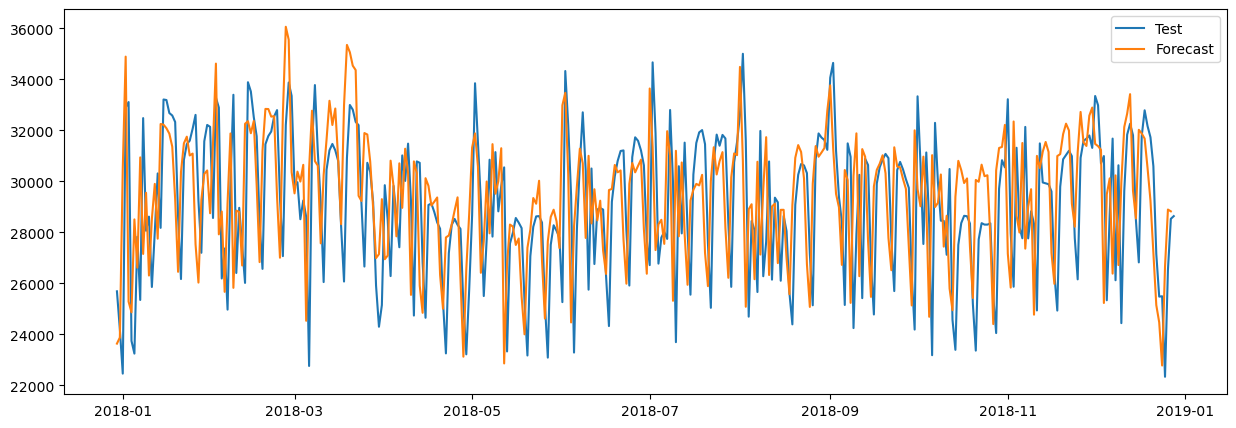

In [ ]:
model.fit(X=X_train, y = y_train)
# Obtain the forecasted values
forecast_7 = model.predict(X=X_test,n_periods=len(y_test))

# Inverse transform the forecasted values
# forecast = scaler.inverse_transform(forecast)

# Create a DataFrame with the forecasted values
forecast_df_7 = pd.DataFrame({'forecast': forecast_7}, index=X_test.index)
# Evaluate the model's performance (e.g., using metrics like RMSE or MAE)
Evaluate(y_test[:-1], forecast_df_7['forecast'][:-1])

# Plot the forecasted values and the actual values

# plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(forecast_df_7['forecast'], label='Forecast')
# plt.fill_between(forecast_df.index, forecast_df['lower_bound'], forecast_df['upper_bound'], color='gray', alpha=0.2)
plt.legend()
plt.show()

# **Apply transformation Before LSTM**

The preprocessing cleans the data by applies these two changes:

1. Applies StandardScaler for the data, that is centers the values from the columns by it's mean.

2. Remove columns that has more than 80% of constant values.

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
def preprocessing(dataframe, scal, scaler = StandardScaler()):
    new_dataframe = dataframe.copy()
    scaler = scaler
    #applying StandardScaler
    if len(new_dataframe.shape)>1:
        if scal :
            scaler.fit(new_dataframe)
        new_values = scaler.transform(new_dataframe)
        new_dataframe.loc[:,new_dataframe.columns.to_list()] = new_values
        
        #remove cols with constant values
        thr = int(dataframe.shape[0]*0.8)
        rm_cols = []
        for col in new_dataframe.columns:
            values,counts = np.unique(new_dataframe[col],return_counts=True)
            if (len(values)==1) or (np.any(counts>thr)):
                rm_cols.append(col)
                
        new_dataframe = new_dataframe.drop(labels=rm_cols,axis="columns")
        
    else:
        if scal :
            new_values = scaler.fit_transform(new_dataframe.values.reshape(-1,1))
        else:
            new_values= scaler.transform(new_dataframe.values.reshape(-1,1))
        new_dataframe = new_values
        
    return scaler , new_dataframe

In [ ]:
scaler , new_X_train = preprocessing(X_train,True)
_,new_X_test = preprocessing(X_test, False,scaler)
s,new_y_train = preprocessing(y_train,True)
_,new_y_test = preprocessing(y_test, False,s)

print("Number of train columns",new_X_train.shape[1])
print("Number of test columns",new_X_test.shape[1])
print("shape of train X",new_X_train.shape)
print("shape of train y",new_y_train.shape)

Number of train columns 30
Number of test columns 30
shape of train X (1092, 30)
shape of train y (1092, 1)


In [ ]:
#remove cols that are in test but not in train and vice-versa
def rm_unseen_cols(train_df,test_df):
    cols_not_in_train = [col for col in test_df.columns if col not in train_df.columns]
    cols_not_in_test = [col for col in train_df.columns if col not in test_df.columns]
    new_X_test_df = test_df.drop(labels=cols_not_in_train,axis="columns")
    new_X_train_df = train_df.drop(labels=cols_not_in_test,axis="columns")
    
    return new_X_train_df, new_X_test_df

new_X_train, new_X_test =rm_unseen_cols(new_X_train,new_X_test)

print("Number of train columns:",new_X_train.shape[1])
print("Number of test columns:",new_X_test.shape[1])

Number of train columns: 29
Number of test columns: 29


In [ ]:
#Creating train and test dataframes with new preprocessing values 

#train dataframe
train_dataframe = new_X_train.copy()
#our target 
train_dataframe["total_load_actual"] = new_y_train

#test dataframe
test_dataframe = new_X_test.copy()
#our target 
test_dataframe["total_load_actual"] = new_y_test

# Apply Sarimax After Transformation

In [ ]:
col = new_X_train.columns.values

# Fit the Auto SARIMAX model to the scaled training data
model_transform = auto_arima(new_y_train, exogenous = train_dataframe[col],seasonal=True, test='adf',error_action='ignore', m = 7,
                           suppress_warnings=True,stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=5.55 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=3102.962, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2899.509, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2873.980, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=3100.962, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=2909.216, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=2873.718, Time=0.74 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=6.59 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=3024.104, Time=1.25 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=2870.031, Time=1.58 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=2870.357, Time=0.88 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.88 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=2903.139, Time=0

Mean Squared error : 1.1995741395877404
Root Mean Squere Error : 1.0952507199667756
r2_score : -0.20782087753926293
Mean absolute percentage error (MAPE) MAPE: 344.28 % 
SMAPE: 124.30 %


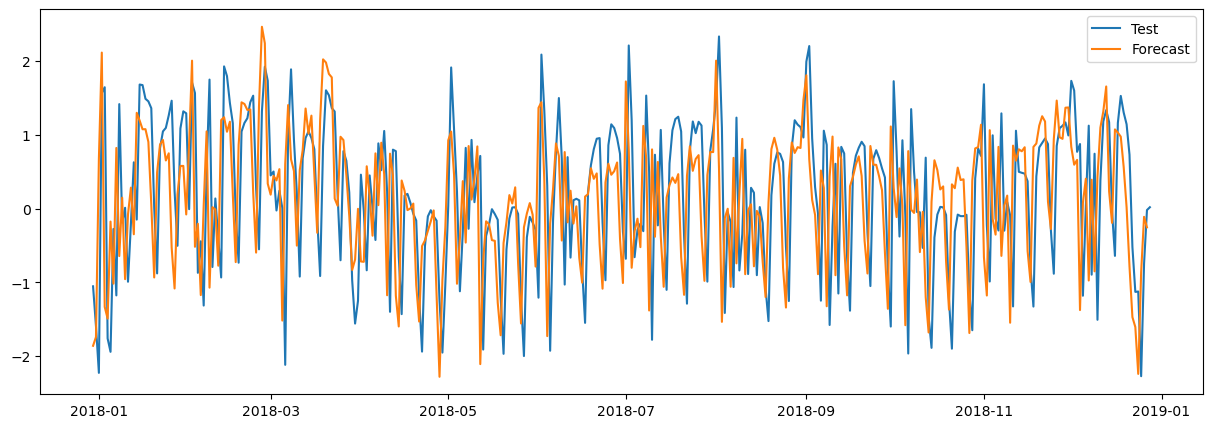

In [ ]:
model_transform.fit(X =new_X_train, y = new_y_train)

# model.fit(X=X_train, y = y_train)
# Obtain the forecasted values
forecast_tras = model_transform.predict(X = new_X_test,n_periods=len(new_y_test))

# Inverse transform the forecasted values
# forecast = scaler.inverse_transform(forecast)

# Create a DataFrame with the forecasted values
forecast_df_trans = pd.DataFrame({'forecast': forecast_tras}, index=new_X_test.index)
actual = pd.DataFrame({'Targets': new_y_test.reshape(-1,)}, index=new_X_test.index)

# Evaluate the model's performance (e.g., using metrics like RMSE or MAE)
Evaluate(actual['Targets'].fillna(0),forecast_df_trans['forecast'].fillna(0))

# Plot the forecasted values and the actual values
# plt.plot(y_train, label='Train')
plt.plot(actual['Targets'], label='Test')
plt.plot(forecast_df_trans['forecast'], label='Forecast')
# plt.fill_between(forecast_df.index, forecast_df['lower_bound'], forecast_df['upper_bound'], color='gray', alpha=0.2)
plt.legend()
plt.show()

In [ ]:
# invers transformaer and evaluate 
# Inverse transform the forecasted values
Y_predict_sarima = s.inverse_transform(forecast_df_trans['forecast'].fillna(0).to_numpy().reshape(-1,1))
Y_true_sarima = s.inverse_transform(actual['Targets'].fillna(0).to_numpy().reshape(-1,1))
Evaluate(Y_true_sarima,Y_predict_sarima)
print('Evaluate after removing last forcat with nan val')
Evaluate(Y_true_sarima[:-1],Y_predict_sarima[:-1])

Mean Squared error : 9078703.173262868
Root Mean Squere Error : 3013.0886434459358
r2_score : -0.2078208775392627
Mean absolute percentage error (MAPE) MAPE: 8.42 % 
SMAPE: 8.33 %
Evaluate after removing last forcat with nan val
Mean Squared error : 9103705.688470118
Root Mean Squere Error : 3017.23477516585
r2_score : -0.20790159022820376
Mean absolute percentage error (MAPE) MAPE: 8.44 % 
SMAPE: 8.35 %


<AxesSubplot:xlabel='datetime'>

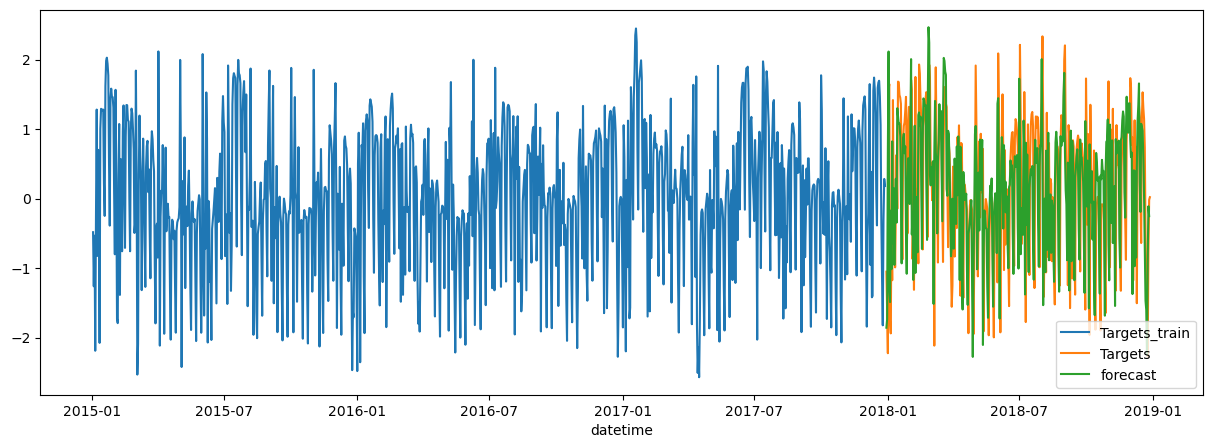

In [ ]:

train_y = pd.DataFrame({'Targets_train': new_y_train.reshape(-1,)}, index=new_X_train.index)
pd.concat([train_y,actual,forecast_df_trans],axis=1).plot()

##  Prepare Data Size For LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

sequence_length = 7
batch_size = 32

features = [col for col in train_dataframe.columns if col != "total_load_actual"]
target = "total_load_actual"

def create_dataset(train_dataframe, test_dataframe, target, n_input, n_out):
    train_gen = TimeseriesGenerator(train_dataframe.values, train_dataframe[target].values,
                                    length=n_input, batch_size=batch_size)
    test_gen = TimeseriesGenerator(test_dataframe.values, test_dataframe[target].values,
                                    length=n_input, batch_size=batch_size)
    return train_gen, test_gen
    
def split_dataset(dataframe):
    sp_df = np.array(np.split(dataframe.values, dataframe.shape[0]/7))
    return sp_df

train_gen, test_gen = create_dataset(train_dataframe, test_dataframe, target, n_input=7, n_out=7)
X_train, y_train = train_gen[0]
print("Train features shape:", X_train.shape)
print("Train target shape:", y_train.shape)

week_train_dataset = split_dataset(train_dataframe)
week_test_dataset = split_dataset(test_dataframe)

print("Week train dataframe shape:", week_train_dataset.shape)
print("Week test dataframe  shape:", week_test_dataset.shape)


Train features shape: (32, 7, 30)
Train target shape: (32,)
Week train dataframe shape: (156, 7, 30)
Week test dataframe  shape: (52, 7, 30)


# **Hybird Models**
# 1. Lstm
# 2. ensembling SARIMA+LSTM (Compining)
# 3. Hybired (SARIMAX+LSTM) apply LSTM on residula output of SARIMAX

#  1. LSTM

# **Rosmop**

===== training Vanilla Lstm =====
Epoch 1/50
34/34 [==============================] - 4s 7ms/step - loss: 0.9948
Epoch 2/50
34/34 [==============================] - 0s 8ms/step - loss: 0.8900
Epoch 3/50
34/34 [==============================] - 0s 8ms/step - loss: 0.8651
Epoch 4/50
34/34 [==============================] - 0s 7ms/step - loss: 0.8244
Epoch 5/50
34/34 [==============================] - 0s 7ms/step - loss: 0.7867
Epoch 6/50
34/34 [==============================] - 0s 6ms/step - loss: 0.7263
Epoch 7/50
34/34 [==============================] - 0s 7ms/step - loss: 0.6906
Epoch 8/50
34/34 [==============================] - 0s 7ms/step - loss: 0.6669
Epoch 9/50
34/34 [==============================] - 0s 7ms/step - loss: 0.6332
Epoch 10/50
34/34 [==============================] - 0s 7ms/step - loss: 0.6023
Epoch 11/50
34/34 [==============================] - 0s 7ms/step - loss: 0.5839
Epoch 12/50
34/34 [==============================] - 0s 7ms/step - loss: 0.5650
Epoch 13/50
34/

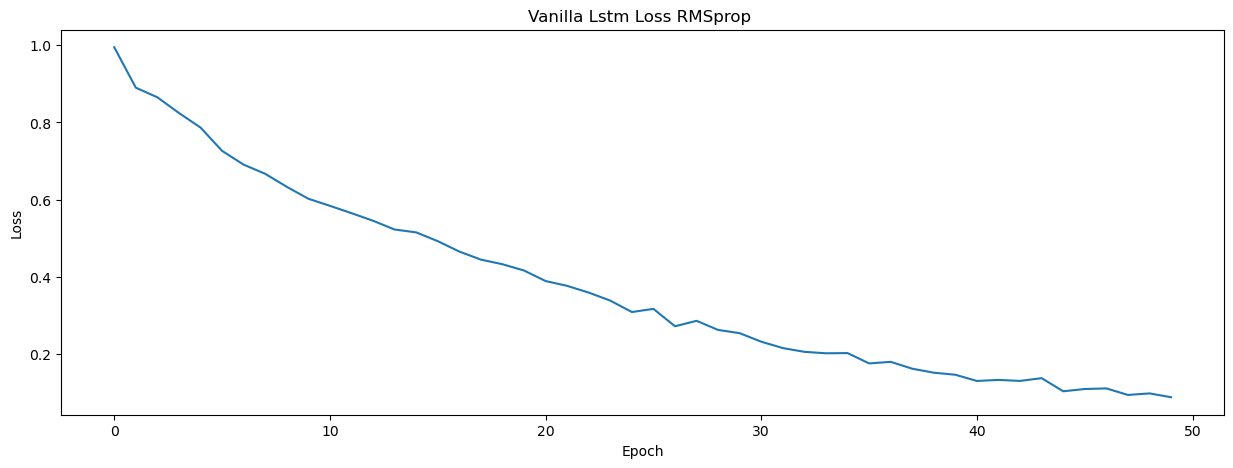

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Train the LSTM model to predict the residuals

n_steps = 7  # Number of previous residuals to use as input
n_features = 1  # Number of features in the input (i.e. only one residual)

# Build the LSTM model
lstm = Sequential()
lstm.add(LSTM(units=200, return_sequences=True, input_shape=(n_steps, n_features)))
lstm.add(LSTM(units=64, return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))
lstm.compile(optimizer='RMSprop', loss='mean_squared_error')
print(f"===== training Vanilla Lstm =====")
# Train the LSTM model

history = lstm.fit(train_gen, epochs=50,batch_size = batch_size)
print(f"==== plot losses - Vanilla Lstm ====== ")
plt.plot(history.history['loss'])
plt.title(f"Vanilla Lstm Loss RMSprop ")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [ ]:
# import math
# pridect
predictions = lstm.predict(test_gen)
score = lstm.evaluate(test_gen)
print(f"MSE score: {score}")
print(f"RMSE score: {np.sqrt(score)}")
Evaluate(test_gen.targets[:len(predictions)],predictions.reshape(-1,))

In [ ]:
# Eval after inverse transformation
# Inverse transform the forecasted values
Y_predict_lstm = s.inverse_transform(predictions)
Y_true_lstm = s.inverse_transform(test_gen.targets[:len(predictions)].reshape(-1,1))
Evaluate(Y_true_lstm,Y_predict_lstm)

<AxesSubplot:xlabel='datetime'>

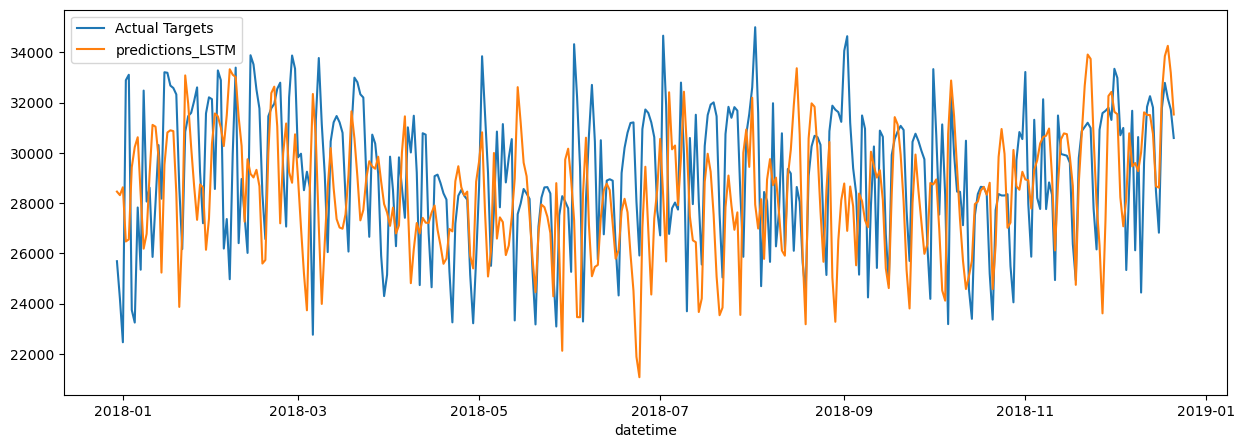

In [ ]:
Df = pd.DataFrame({'Actual Targets': Y_true_lstm.reshape(-1,), 'predictions_LSTM':Y_predict_lstm.reshape(-1,)},
                 index=test_dataframe[:len(predictions)].index)
Df.plot()

# **Adam**

In [ ]:
# pridect
predictions = lstm.predict(test_gen)
score = lstm.evaluate(test_gen)
print(f"MSE score: {score}")
Evaluate(test_gen.targets[:len(predictions)],predictions.reshape(-1,))

12/12 [==============================] - 1s 5ms/step - loss: 1.2308
MSE score: 1.2307758331298828
Mean Squared error : 1.3410148802754398
Root Mean Squere Error : 1.1580219688224571
r2_score : -0.3654530521123869
Mean absolute percentage error (MAPE) MAPE: 322.35 % 
SMAPE: 138.28 %


In [ ]:
# Eval after inverse transformation
# Inverse transform the forecasted values
Y_predict_lstm = s.inverse_transform(predictions)
Y_true_lstm = s.inverse_transform(test_gen.targets[:len(predictions)].reshape(-1,1))
Evaluate(Y_true_lstm,Y_predict_lstm)

Mean Squared error : 10149165.36214571
Root Mean Squere Error : 3185.7754726511585
r2_score : -0.3654530810349974
Mean absolute percentage error (MAPE) MAPE: 8.88 % 
SMAPE: 8.94 %


<AxesSubplot:xlabel='datetime'>

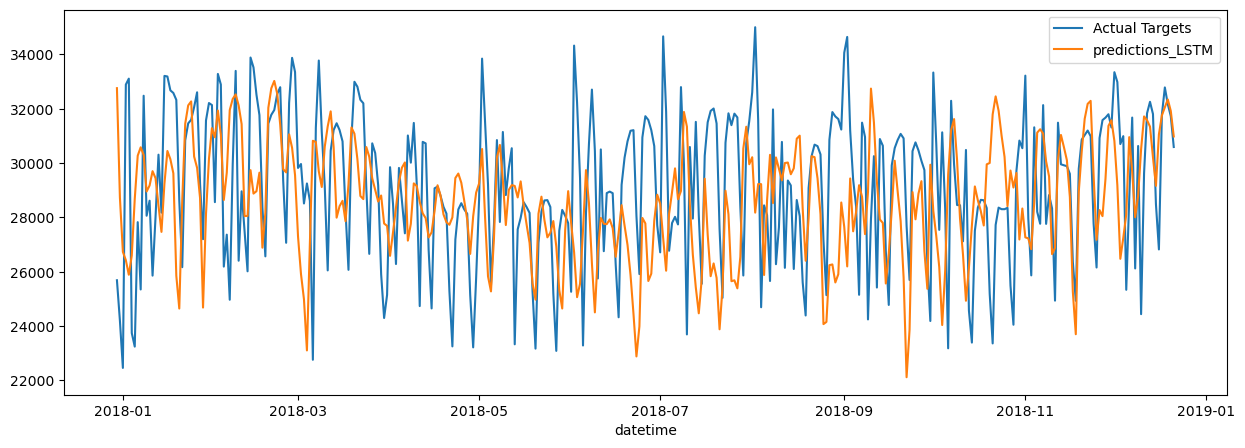

In [ ]:
Df = pd.DataFrame({'Actual Targets': Y_true_lstm.reshape(-1,), 'predictions_LSTM':Y_predict_lstm.reshape(-1,)},
                 index=test_dataframe[:len(predictions)].index)
Df.plot()

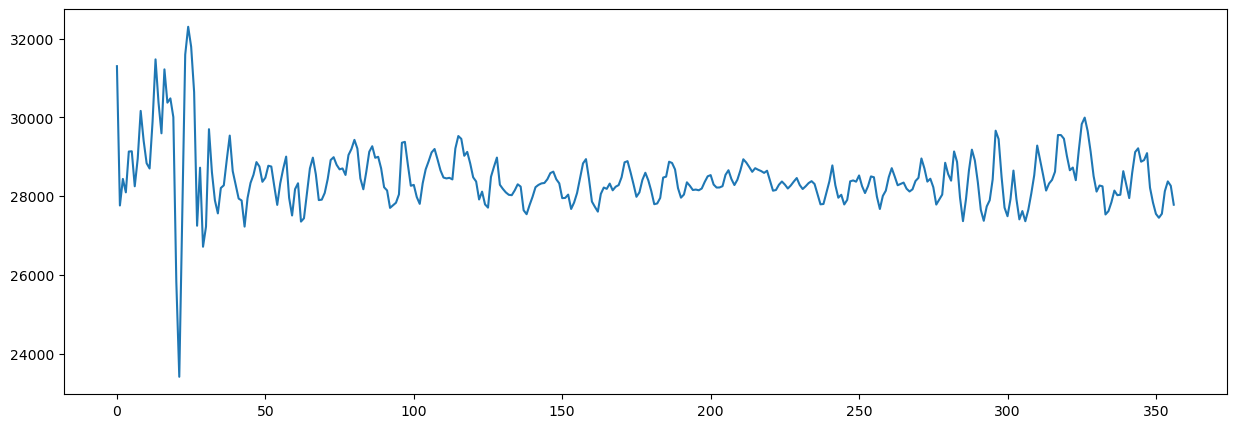

In [ ]:
plt.plot(Y_predict_lstm.reshape(-1,))

In [ ]:
Df.head(30)

Actual Targets  predictions_LSTM
datetime                                    
2017-12-30    25689.041667      31299.197266
2017-12-31    24203.541667      27761.158203
2018-01-01    22462.000000      28435.431641
2018-01-02    32893.458333      28094.693359
2018-01-03    33111.458333      29131.279297
2018-01-04    23745.125000      29137.486328
2018-01-05    23246.916667      28248.619141
2018-01-06    27827.541667      28951.328125
2018-01-07    25350.166667      30163.216797
2018-01-08    32481.583333      29403.568359
2018-01-09    28064.750000      28833.714844
2018-01-10    28617.250000      28700.587891
2018-01-11    25859.375000      29888.216797
2018-01-12    28015.708333      31472.404297
2018-01-13    30312.000000      30383.308594
2018-01-14    28177.375000      29594.150391
2018-01-15    33212.041667      31218.455078
2018-01-16    33190.583333      30372.943359
2018-01-17    32680.083333      30481.433594
2018-01-18    32584.500000      30004.777344
2018-01-19    32329.500000      25823.320312
2018-01-20    28623.416667      23410.238281
2018-01-21    26170.208333      27510.943359
2018-01-22    30841.750000      31592.562500
2018-01-23    31464.000000      32300.171875
2018-01-24    31596.000000      31792.744141
2018-01-25    32064.458333      30641.919922
2018-01-26    32608.125000      27246.875000
2018-01-27    29239.541667      28720.808594
2018-01-28    27200.458333      26713.384766

In [ ]:
fig = plt.figure(figsize=(10,10))

for week in range(9):
    Df.iloc[week*40:(week+1)*40].plot()
    fig.add_subplot()
    plt.title(f'Consumption profile for 2018 Week: {week+1}')

# Bidirection-Lstm

===== training model_bilstm =====
Epoch 1/50
34/34 [==============================] - 10s 11ms/step - loss: 1.0275
Epoch 2/50
34/34 [==============================] - 0s 11ms/step - loss: 0.8569
Epoch 3/50
34/34 [==============================] - 0s 11ms/step - loss: 0.7492
Epoch 4/50
34/34 [==============================] - 0s 11ms/step - loss: 0.7255
Epoch 5/50
34/34 [==============================] - 0s 11ms/step - loss: 0.6619
Epoch 6/50
34/34 [==============================] - 0s 11ms/step - loss: 0.6299
Epoch 7/50
34/34 [==============================] - 0s 11ms/step - loss: 0.5577
Epoch 8/50
34/34 [==============================] - 0s 11ms/step - loss: 0.5030
Epoch 9/50
34/34 [==============================] - 0s 11ms/step - loss: 0.4935
Epoch 10/50
34/34 [==============================] - 0s 11ms/step - loss: 0.5250
Epoch 11/50
34/34 [==============================] - 0s 11ms/step - loss: 0.4956
Epoch 12/50
34/34 [==============================] - 0s 11ms/step - loss: 0.4513
Ep

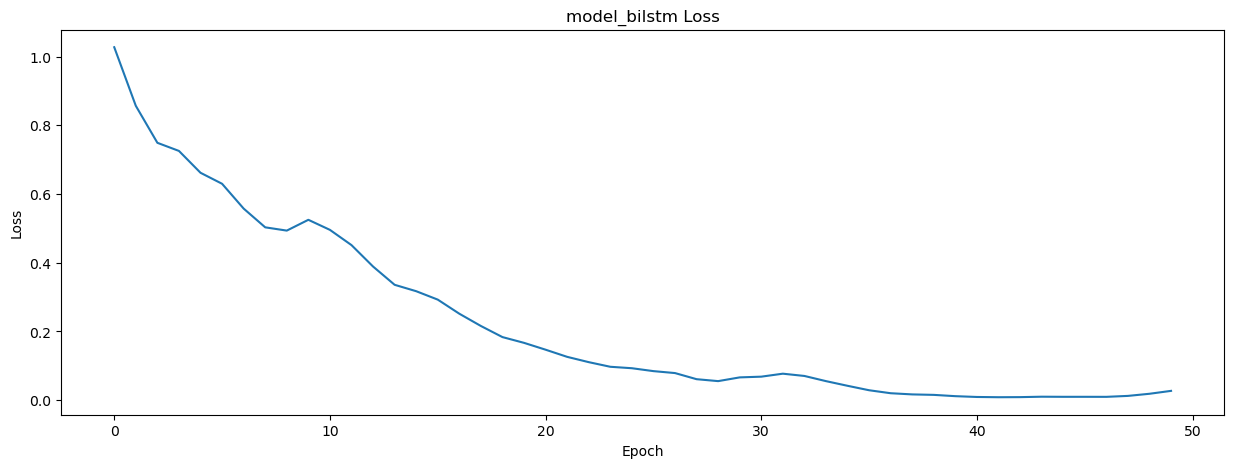

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


===== scores for model_bilstm ====
MSE score: 1.0188785791397095


In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from sklearn.metrics import mean_squared_error

input_dim = X_train.shape[2]
n_seq = 7
batch_size = 32
output_dim = 1
hidden_dim = 200
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'output_dim' : output_dim,
                }

models = {

    "model_bilstm": Sequential([
        Bidirectional(LSTM(hidden_dim,  return_sequences=True, input_shape=(n_seq, input_dim))),
        Bidirectional(LSTM(64)),    
        Dense(output_dim)
    ])
}
# models = {
#     "vanilla_lstm":LSTMModel(**model_params,layer_dim=1,is_bidirectional=False,dropout_prob=0),
#     "stacked_lstm":LSTMModel(**model_params,layer_dim=2,is_bidirectional=False,dropout_prob=0.2),
#     "model_bilstm":LSTMModel(**model_params,layer_dim=1,is_bidirectional=True,dropout_prob=0)
# }



loss_fn = MeanSquaredError()
opts = []
for name_model, model in models.items():
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate, weight_decay=weight_decay)
    model.compile(loss=loss_fn, optimizer=optimizer)
    opts.append((f"{name_model}", model))

if not os.path.exists("/kaggle/working/models"):
    os.makedirs("/kaggle/working/models")

predictions_by_model = {
    "vanilla_lstm":[],
    "stacked_lstm":[],
    "model_bilstm":[]
}


    
    
for name_model, model in opts:
    print(f"===== training {name_model} =====")
    history = model.fit(train_gen, epochs=50,batch_size = batch_size)
    print(f"==== plot losses - {name_model} ====== ")
    plt.plot(history.history['loss'])
    plt.title(f"{name_model} Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
#     score = model.evaluate(week_test_dataset)
    predictions = model.predict_generator(test_gen)
    score = model.evaluate_generator(test_gen)
#     score = mean_squared_error(predictions,week_test_dataset)
    predictions_by_model[name_model].append(predictions)
    # summarize scores
    print(f"===== scores for {name_model} ====")
    print(f"MSE score: {score}")


Mean Squared error : 1.1876033168887343
Root Mean Squere Error : 1.0897721398938103
r2_score : -0.2092457716885605
Mean absolute percentage error (MAPE) MAPE: 283.92 % 
SMAPE: 134.54 %


<AxesSubplot:xlabel='datetime'>

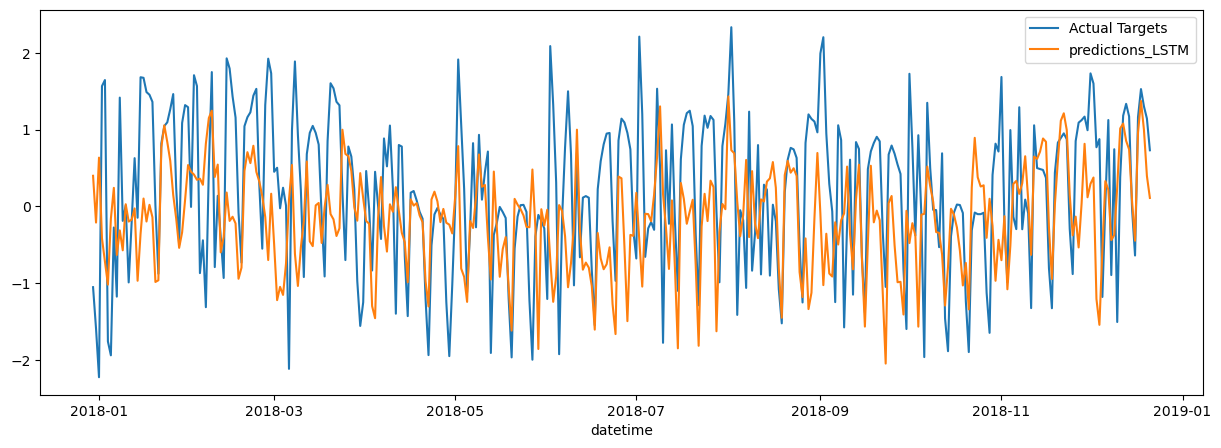

In [ ]:
pridection_bi = np.array(predictions_by_model['model_bilstm']).reshape(-1,)
Evaluate(test_gen.targets[:len(pridection_bi)],pridection_bi)
Df = pd.DataFrame({'Actual Targets': test_gen.targets[:len(pridection_bi)], 'predictions_LSTM':pridection_bi},
                 index=test_dataframe[:len(pridection_bi)].index)
Df.plot()


Mean Squared error : 8988104.881664129
Root Mean Squere Error : 2998.0168247800293
r2_score : -0.20924579168934665
Mean absolute percentage error (MAPE) MAPE: 8.09 % 
SMAPE: 8.28 %


<AxesSubplot:xlabel='datetime'>

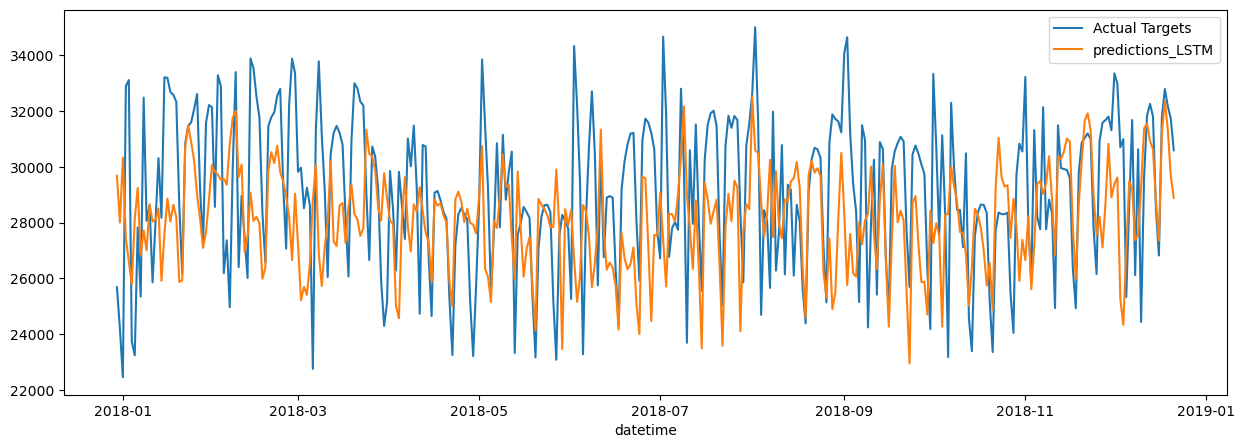

In [ ]:
# Eval after inverse transformation
# Inverse transform the forecasted values
Y_predict_bi = s.inverse_transform(pridection_bi.reshape(-1,1))
Y_true_bi = s.inverse_transform(test_gen.targets[:len(pridection_bi)].reshape(-1,1))
Evaluate(Y_true_bi,Y_predict_bi)
Df_bi = pd.DataFrame({'Actual Targets': Y_true_bi.reshape(-1,), 'predictions_LSTM':Y_predict_bi.reshape(-1,)},
                 index=test_dataframe[:len(pridection_bi)].index)
Df_bi.plot()

===== training model_bilstm =====
Epoch 1/50
34/34 [==============================] - 5s 7ms/step - loss: 1.0327
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 0.8400
Epoch 3/50
34/34 [==============================] - 0s 8ms/step - loss: 0.7388
Epoch 4/50
34/34 [==============================] - 0s 8ms/step - loss: 0.7081
Epoch 5/50
34/34 [==============================] - 0s 7ms/step - loss: 0.6540
Epoch 6/50
34/34 [==============================] - 0s 7ms/step - loss: 0.5761
Epoch 7/50
34/34 [==============================] - 0s 7ms/step - loss: 0.5725
Epoch 8/50
34/34 [==============================] - 0s 7ms/step - loss: 0.5450
Epoch 9/50
34/34 [==============================] - 0s 7ms/step - loss: 0.4982
Epoch 10/50
34/34 [==============================] - 0s 8ms/step - loss: 0.4515
Epoch 11/50
34/34 [==============================] - 0s 8ms/step - loss: 0.4356
Epoch 12/50
34/34 [==============================] - 0s 7ms/step - loss: 0.4016
Epoch 13/50
34/

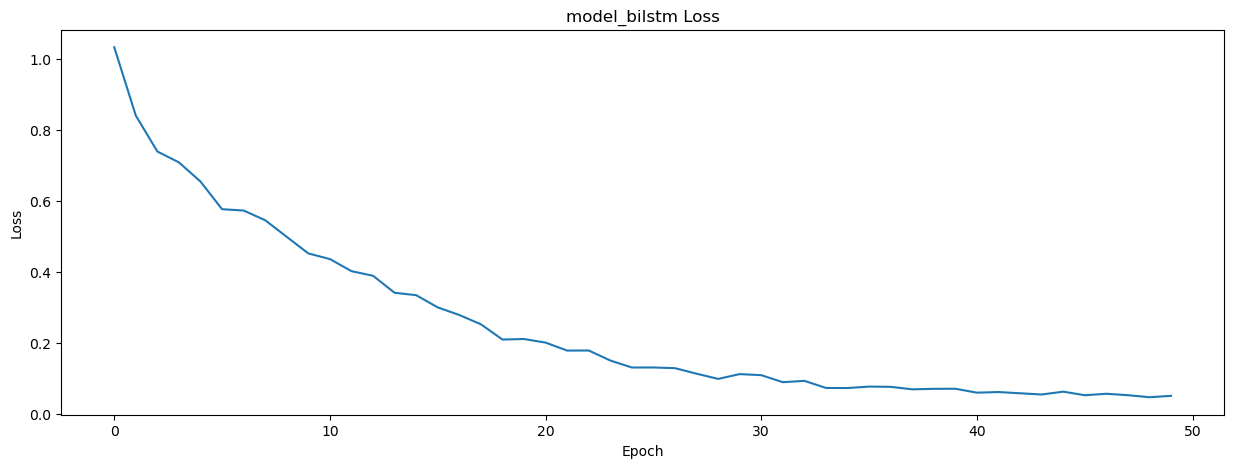

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


===== scores for model_bilstm ====
MSE score: 0.9063116312026978


In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from sklearn.metrics import mean_squared_error

input_dim = X_train.shape[2]
n_seq = 7
batch_size = 32
output_dim = 1
hidden_dim = 200
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'output_dim' : output_dim,
                }

models = {
#     "vanilla_lstm": Sequential([
#         LSTM(hidden_dim, input_shape=(n_seq, input_dim)),
#         Dense(output_dim)
#     ]),
#     "stacked_lstm": Sequential([
#         LSTM(hidden_dim, input_shape=(n_seq, input_dim), return_sequences=True),
#         Dropout(0.2),
#         LSTM(hidden_dim),
#         Dense(output_dim)
#     ]),
    "model_bilstm": Sequential([
        Bidirectional(LSTM(hidden_dim, input_shape=(n_seq, input_dim))),
        Dropout(0.1),
        Dense(output_dim)
    ])
}
# models = {
#     "vanilla_lstm":LSTMModel(**model_params,layer_dim=1,is_bidirectional=False,dropout_prob=0),
#     "stacked_lstm":LSTMModel(**model_params,layer_dim=2,is_bidirectional=False,dropout_prob=0.2),
#     "model_bilstm":LSTMModel(**model_params,layer_dim=1,is_bidirectional=True,dropout_prob=0)
# }



loss_fn = MeanSquaredError()
opts = []
for name_model, model in models.items():
    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate, weight_decay=weight_decay)
    model.compile(loss=loss_fn, optimizer=optimizer)
    opts.append((f"{name_model}", model))

if not os.path.exists("/kaggle/working/models"):
    os.makedirs("/kaggle/working/models")

predictions_by_model = {
    "vanilla_lstm":[],
    "stacked_lstm":[],
    "model_bilstm":[]
}


    
    
for name_model, model in opts:
    print(f"===== training {name_model} =====")
    history = model.fit(train_gen, epochs=50,batch_size = batch_size)
    print(f"==== plot losses - {name_model} ====== ")
    plt.plot(history.history['loss'])
    plt.title(f"{name_model} Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
#     score = model.evaluate(week_test_dataset)
    predictions = model.predict_generator(test_gen)
    score = model.evaluate_generator(test_gen)
#     score = mean_squared_error(predictions,week_test_dataset)
    predictions_by_model[name_model].append(predictions)
    # summarize scores
    print(f"===== scores for {name_model} ====")
    print(f"MSE score: {score}")


Mean Squared error : 1.0177949494688647
Root Mean Squere Error : 1.008858240521861
r2_score : -0.03634287778475942
Mean absolute percentage error (MAPE) MAPE: 309.62 % 
SMAPE: 127.14 %


<AxesSubplot:xlabel='datetime'>

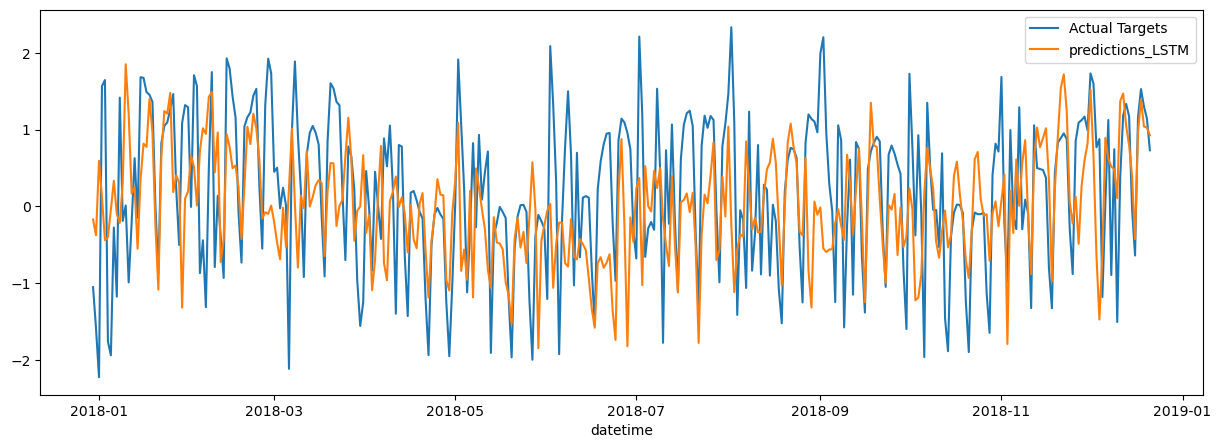

In [ ]:
pridection_bi_2 = np.array(predictions_by_model['model_bilstm']).reshape(-1,)
Evaluate(test_gen.targets[:len(pridection_bi_2)],pridection_bi_2)
Df = pd.DataFrame({'Actual Targets': test_gen.targets[:len(pridection_bi_2)], 'predictions_LSTM':pridection_bi_2},
                 index=test_dataframe[:len(pridection_bi_2)].index)
Df.plot()


Mean Squared error : 7702948.408667145
Root Mean Squere Error : 2775.4186006199398
r2_score : -0.036342818582718595
Mean absolute percentage error (MAPE) MAPE: 7.59 % 
SMAPE: 7.66 %


<AxesSubplot:xlabel='datetime'>

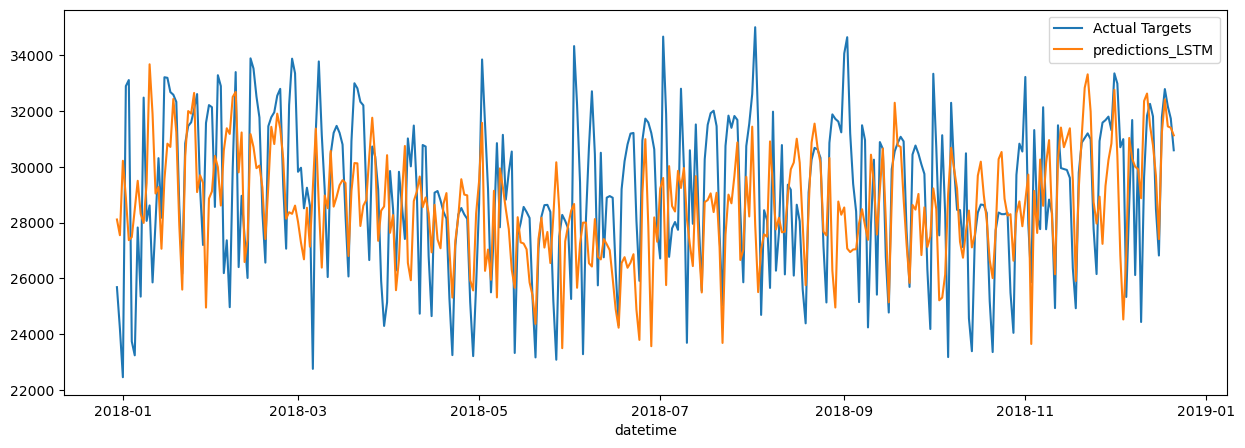

In [ ]:
# Eval after inverse transformation
# Inverse transform the forecasted values
Y_predict_bi_2 = s.inverse_transform(pridection_bi_2.reshape(-1,1))
Y_true_bi_2 = s.inverse_transform(test_gen.targets[:len(pridection_bi_2)].reshape(-1,1))
Evaluate(Y_true_bi_2,Y_predict_bi_2)
Df_bi_2 = pd.DataFrame({'Actual Targets': Y_true_bi_2.reshape(-1,), 'predictions_LSTM':Y_predict_bi_2.reshape(-1,)},
                 index=test_dataframe[:len(pridection_bi_2)].index)
Df_bi_2.plot()

### adam

Mean Squared error : 8220767.465345579
Root Mean Squere Error : 2867.1880763817326
r2_score : -0.10600939717620395
Mean absolute percentage error (MAPE) MAPE: 7.81 % 
SMAPE: 7.94 %


<AxesSubplot:xlabel='datetime'>

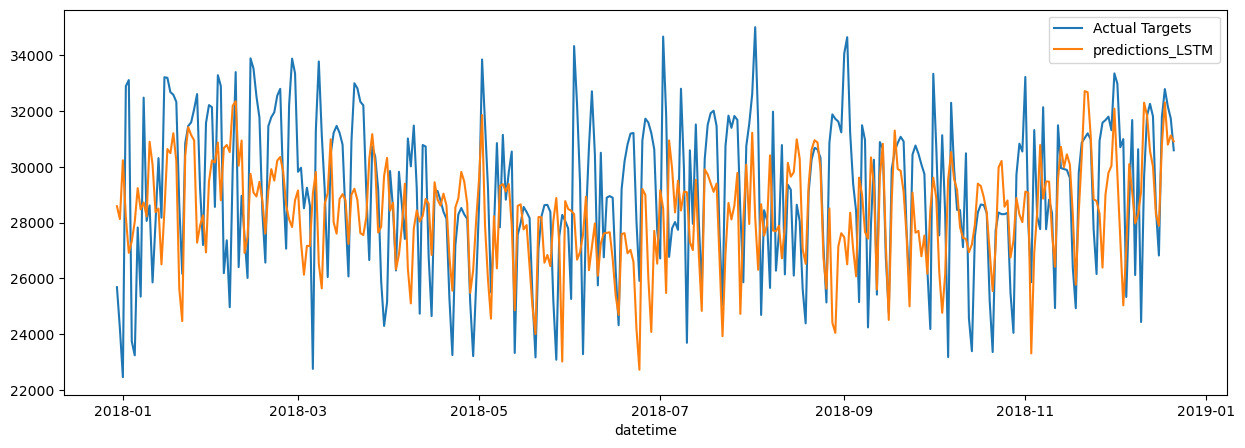

In [ ]:
# Eval after inverse transformation
# Inverse transform the forecasted values
Y_predict_bi_2 = s.inverse_transform(pridection_bi_2.reshape(-1,1))
Y_true_bi_2 = s.inverse_transform(test_gen.targets[:len(pridection_bi_2)].reshape(-1,1))
Evaluate(Y_true_bi_2,Y_predict_bi_2)
Df_bi_2 = pd.DataFrame({'Actual Targets': Y_true_bi_2.reshape(-1,), 'predictions_LSTM':Y_predict_bi_2.reshape(-1,)},
                 index=test_dataframe[:len(pridection_bi_2)].index)
Df_bi_2.plot()

In [ ]:
# Eval after inverse transformation
# Inverse transform the forecasted values
Y_predict_bi_2 = s.inverse_transform(pridection_bi_2.reshape(-1,1))
Y_true_bi_2 = s.inverse_transform(test_gen.targets[:len(pridection_bi_2)].reshape(-1,1))
Evaluate(Y_true_bi_2,Y_predict_bi_2)
Df_bi_2 = pd.DataFrame({'Actual Targets': Y_true_bi_2.reshape(-1,), 'predictions_LSTM':Y_predict_bi_2.reshape(-1,)},
                 index=test_dataframe[:len(pridection_bi_2)].index)
Df_bi_2.plot()

# **Ensembling****

# Bidirectional+Sarima

Mean Squared error : 0.8815484581356386
Root Mean Squere Error : 0.9389081201777086
r2_score : 0.10238652049928176
Mean absolute percentage error (MAPE) MAPE: 267.64 % 
SMAPE: 126.75 %


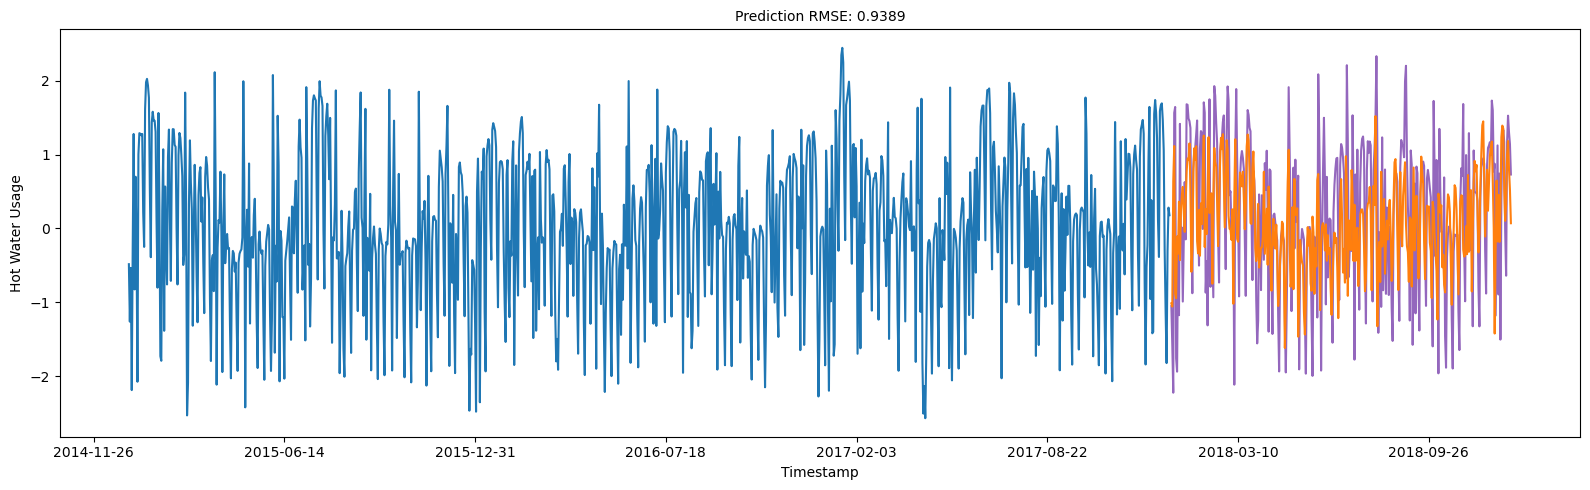

In [ ]:
ensemble_preds = np.add(forecast_df_trans.forecast[:len(pridection_bi_2)], pridection_bi_2.reshape(-1,))/2
rmse = mean_squared_error(actual['Targets'][:len(pridection_bi_2)], ensemble_preds, squared=False)
Evaluate(test_gen.targets[:len(pridection_bi_2)],ensemble_preds)
nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(16,5))

ax1 = plt.subplot(nrows, ncols, 1)
ax1.plot( train_dataframe.total_load_actual, c='tab:blue')
ax1.plot( actual['Targets'][:len(pridection_bi_2)], c='tab:purple')
ax1.plot( ensemble_preds,  c='tab:orange')
ax1.set_ylabel('Hot Water Usage')
ax1.set_xlabel('Timestamp')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)

plt.tight_layout()
plt.show()

Mean Squared error : 6671798.2407167405
Root Mean Squere Error : 2582.98243136045
r2_score : 0.10238653733940839
Mean absolute percentage error (MAPE) MAPE: 7.24 % 
SMAPE: 7.21 %


<AxesSubplot:xlabel='datetime'>

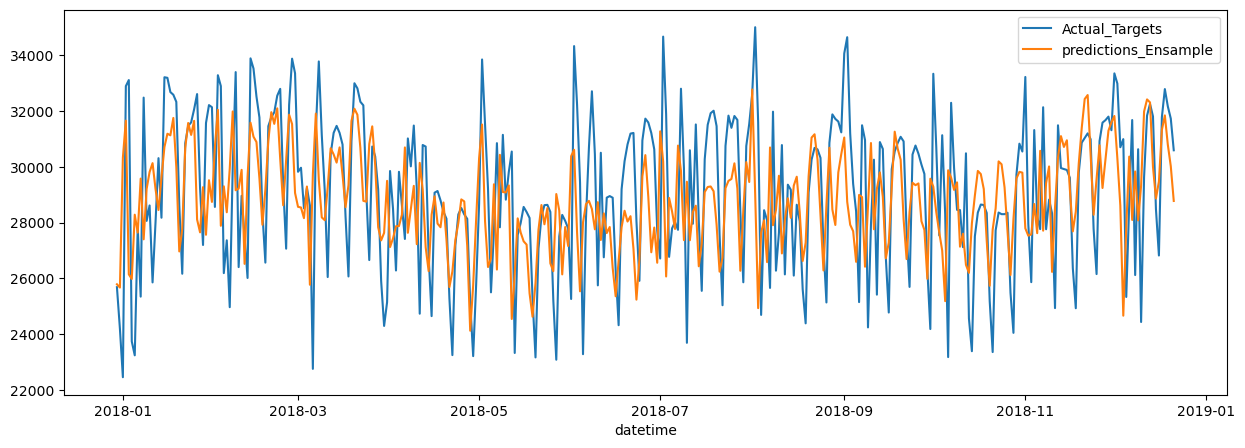

In [ ]:
ensemble_preds = np.add(Y_predict_sarima[:len(Y_predict_bi_2)], Y_predict_bi_2)/2
rmse = mean_squared_error(Y_true_sarima[:len(Y_predict_bi_2)], ensemble_preds, squared=False)
Evaluate(Y_true_sarima[:len(Y_predict_bi_2)],ensemble_preds)

Df_ens= pd.DataFrame({'Actual_Targets': Y_true_sarima[:len(Y_predict_bi_2)].reshape(-1,), 'predictions_Ensample':ensemble_preds.reshape(-1,)},
                 index=test_dataframe[:len(pridection_bi_2)].index)
Df_ens.plot()

# nrows, ncols = 1, 1
# fig, ax = plt.subplots(nrows, ncols, figsize=(16,5))

# ax1 = plt.subplot(nrows, ncols, 1)
# ax1.plot( train_dataframe.total_load_actual, c='tab:blue')
# ax1.plot( Df_ens.Actual_Targets, c='tab:purple')
# ax1.plot( Df_ens.predictions_Ensample,  c='#7FB285')
# ax1.set_ylabel('Hot Water Usage')
# ax1.set_xlabel('Timestamp')
# ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)

# plt.tight_layout()
# plt.show()

In [ ]:
from scipy.optimize import minimize
# Step 5: Ensemble Model
def ensemble_model(weights):
    return np.dot(weights, np.array([forecast_df_trans.forecast[:len(pridection_bi_2)], pridection_bi_2.reshape(-1,)]))

def loss_function(weights):
    ensemble_predictions = ensemble_model(weights)
    return mean_squared_error(actual['Targets'][:len(pridection_bi_2)], ensemble_predictions)

# Step 6: Optimize Ensemble Weights
initial_weights = np.array([0.5, 0.5])  # Initial weights for Auto-ARIMA and LSTM
optimized_weights = minimize(loss_function, initial_weights, method='Nelder-Mead').x
print(optimized_weights)
# Step 7: Evaluate and Fine-tune (if necessary)

# Step 8: Prediction
final_predictions_trans = series = ensemble_model(optimized_weights).reshape(-1,)

[0.29146246 0.40537704]


Mean Squared error : 0.8375274368196892
Root Mean Squere Error : 0.9151652510993242
r2_score : 0.14720976504122263
Mean absolute percentage error (MAPE) MAPE: 208.26 % 
SMAPE: 134.14 %


<AxesSubplot:xlabel='datetime'>

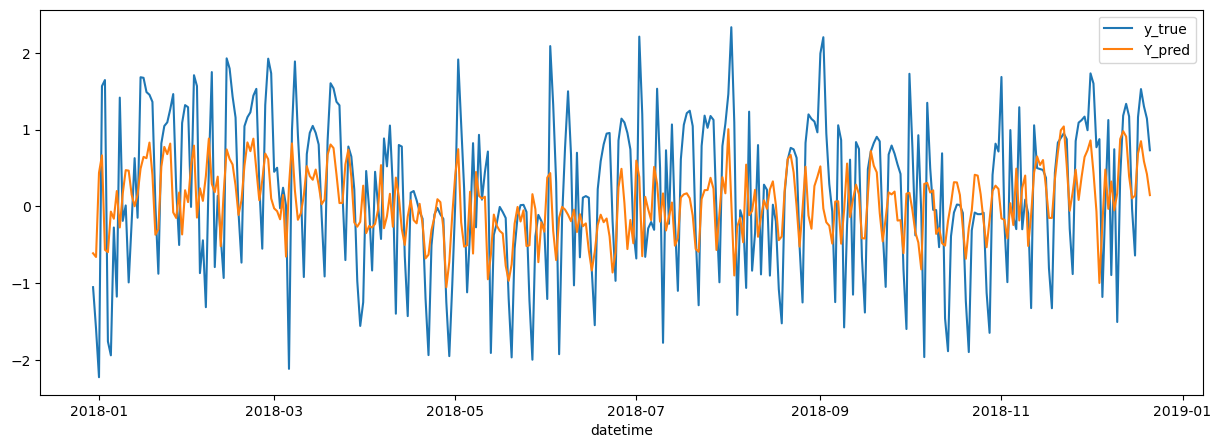

In [ ]:
rmse = mean_squared_error(actual['Targets'][:len(final_predictions_trans)], final_predictions_trans, squared=False)
Evaluate(test_gen.targets[:len(final_predictions_trans)],final_predictions_trans)
pd.DataFrame({'y_true':actual['Targets'][:len(final_predictions_trans)],'Y_pred':final_predictions_trans},index=actual['Targets'][:len(final_predictions_trans)].index).plot()

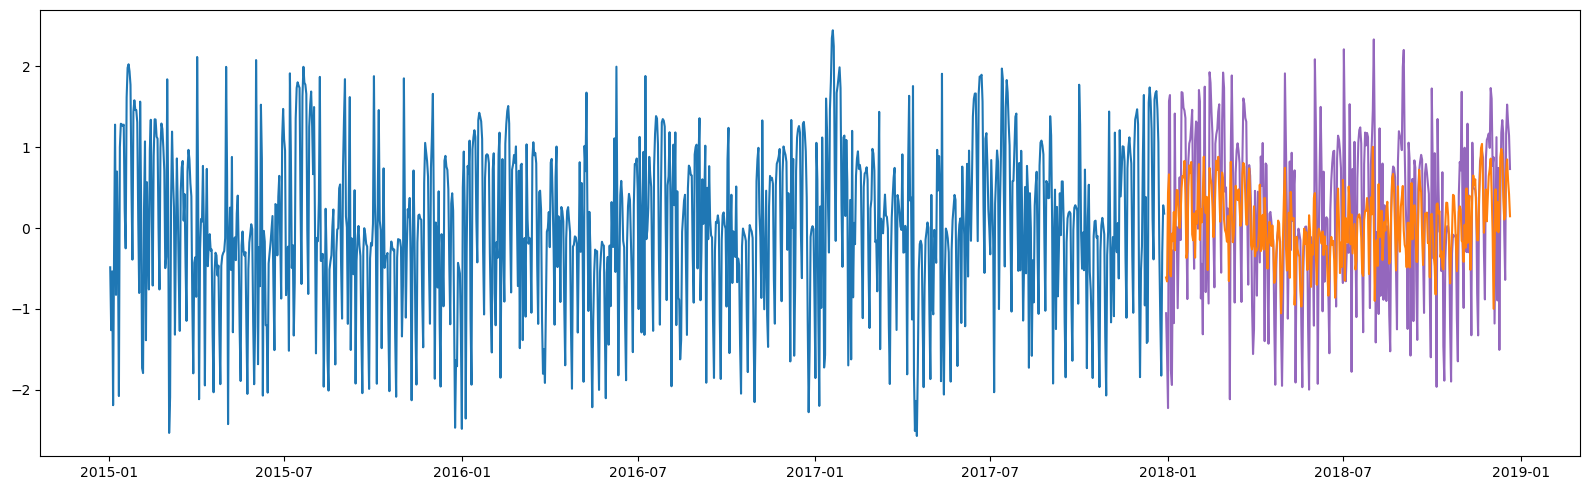

In [ ]:
nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(16,5))
df=pd.DataFrame({'ensample':final_predictions_trans},index=actual['Targets'][:len(final_predictions_trans)].index)
ax1 = plt.subplot(nrows, ncols, 1)
ax1.plot( train_dataframe.total_load_actual, c='tab:blue')
ax1.plot( actual['Targets'][:len(final_predictions_trans)], c='tab:purple')
ax1.plot( df.ensample ,  c='tab:orange')
plt.tight_layout()
plt.show()

Mean Squared error : 6338635.310163316
Root Mean Squere Error : 2517.6646540322477
r2_score : 0.14720976504122252
Mean absolute percentage error (MAPE) MAPE: 7.16 % 
SMAPE: 7.15 %


<AxesSubplot:xlabel='datetime'>

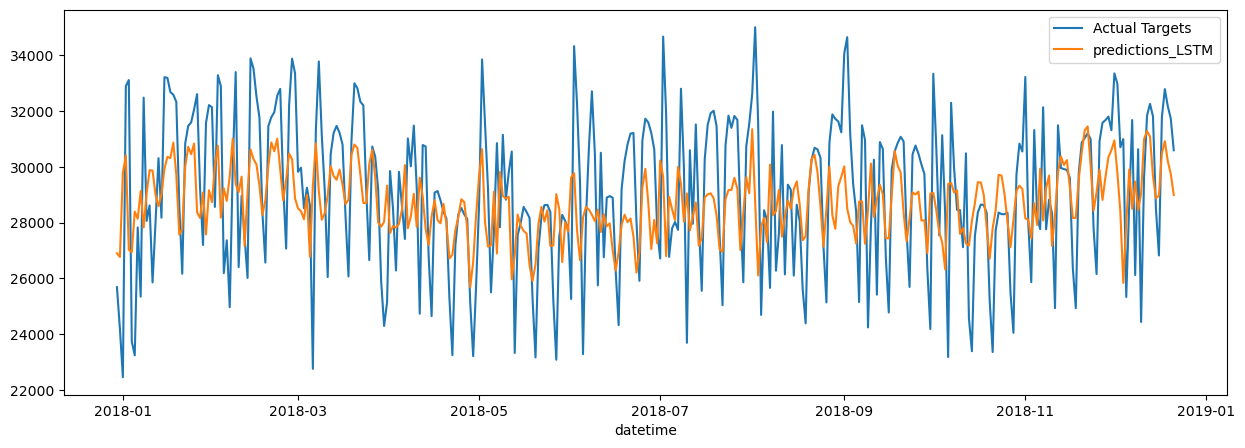

In [ ]:
# Eval after inverse transformation
# Inverse transform the forecasted values
pred = s.inverse_transform(final_predictions_trans.reshape(-1,1))
Y = s.inverse_transform(test_gen.targets[:len(final_predictions_trans)].reshape(-1,1))
Evaluate(Y,pred)
Df_bi_2 = pd.DataFrame({'Actual Targets': Y.reshape(-1,), 'predictions_LSTM':pred.reshape(-1,)},
                 index=test_dataframe[:len(final_predictions_trans)].index)
Df_bi_2.plot()

# **Conclusion**
##As we can see Using ensembling model (SARIMAX-LSTM) We improved the performance.

# Vanilla + SARIMa

In [ ]:
# ensemble_preds = np.add(forecast_df_trans.forecast[:len(predictions)], predictions.reshape(-1,))/2
# rmse = mean_squared_error(actual['Targets'][:len(predictions)], ensemble_preds, squared=False)
# Evaluate(test_gen.targets[:len(predictions)],ensemble_preds)
# nrows, ncols = 1, 1
# fig, ax = plt.subplots(nrows, ncols, figsize=(16,5))

# ax1 = plt.subplot(nrows, ncols, 1)
# ax1.plot( actual['Targets'][:len(predictions)], c='tab:purple')
# ax1.plot( ensemble_preds,  c='tab:orange')
# ax1.set_ylabel('Hot Water Usage')
# ax1.set_xlabel('Timestamp')
# ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)

# plt.tight_layout()
# plt.show()

In [ ]:
# ensemble_preds = np.add(forecast_df_trans.forecast[:len(predictions)], predictions.reshape(-1,))/2
# rmse = mean_squared_error(actual['Targets'][:len(predictions)], ensemble_preds, squared=False)
# Evaluate(test_gen.targets[:len(predictions)],ensemble_preds)
# nrows, ncols = 1, 1
# fig, ax = plt.subplots(nrows, ncols, figsize=(16,5))

# ax1 = plt.subplot(nrows, ncols, 1)
# ax1.plot( train_dataframe.total_load_actual, c='tab:blue')
# ax1.plot( actual['Targets'][:len(predictions)], c='tab:purple')
# ax1.plot( ensemble_preds,  c='tab:orange')
# ax1.set_ylabel('Hot Water Usage')
# ax1.set_xlabel('Timestamp')
# ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax1.set_title('Prediction RMSE: {:.4f}'.format(rmse), fontsize=10)

# plt.tight_layout()
# plt.show()

# Optimize whiehts of ensamplin BidirectionLstm and Sarima

In [ ]:
from scipy.optimize import minimize
# Step 5: Ensemble Model
def ensemble_model(weights):
    return np.dot(weights, np.array([Y_true_sarima[:len(Y_predict_bi_2)].reshape(-1,), Y_predict_bi_2.reshape(-1,)]))

def loss_function(weights):
    ensemble_predictions = ensemble_model(weights)
    return mean_squared_error(Y_true_sarima[:len(Y_predict_bi_2)], ensemble_predictions)

# Step 6: Optimize Ensemble Weights
initial_weights = np.array([0.5, 0.5])  # Initial weights for Auto-ARIMA and LSTM
optimized_weights = minimize(loss_function, initial_weights, method='Nelder-Mead').x
print(optimized_weights)
# Step 7: Evaluate and Fine-tune (if necessary)

# Step 8: Prediction
final_predictions = series = ensemble_model(optimized_weights).reshape(-1,)

[ 1.00000076e+00 -9.25223379e-07]


Mean Squared error : 2.3824496572076492e-05
Root Mean Squere Error : 0.004881034375219713
r2_score : 0.9999999999967947
Mean absolute percentage error (MAPE) MAPE: 10.89 % 
SMAPE: 10.80 %


<AxesSubplot:xlabel='datetime'>

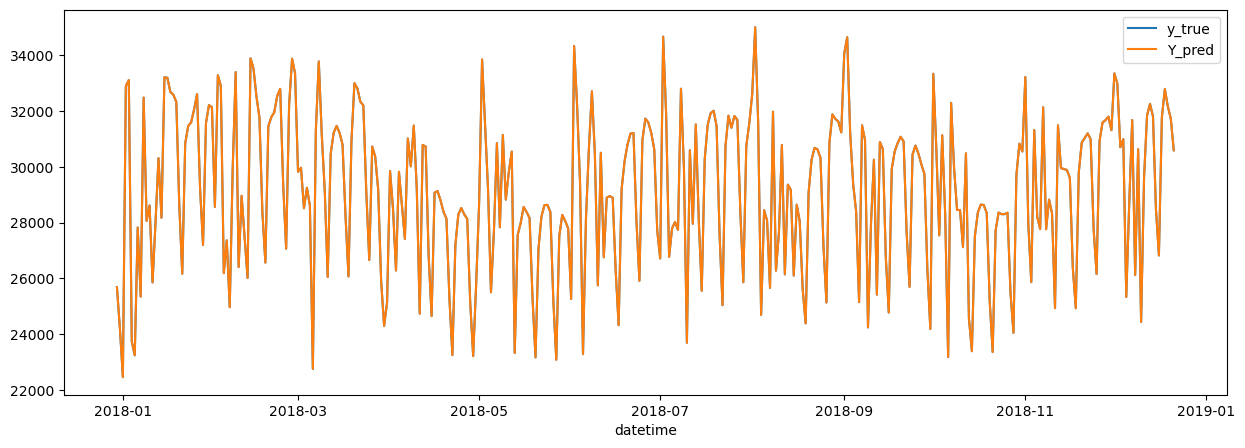

In [ ]:
rmse = mean_squared_error(Y_true_sarima[:len(final_predictions)], final_predictions, squared=False)
Evaluate(Y_true_sarima[:len(final_predictions)],final_predictions)
df_final= pd.DataFrame({'y_true':Y_true_sarima[:len(final_predictions)].reshape(-1,),'Y_pred':final_predictions},index=actual['Targets'][:len(final_predictions)].index)
df_final.plot()

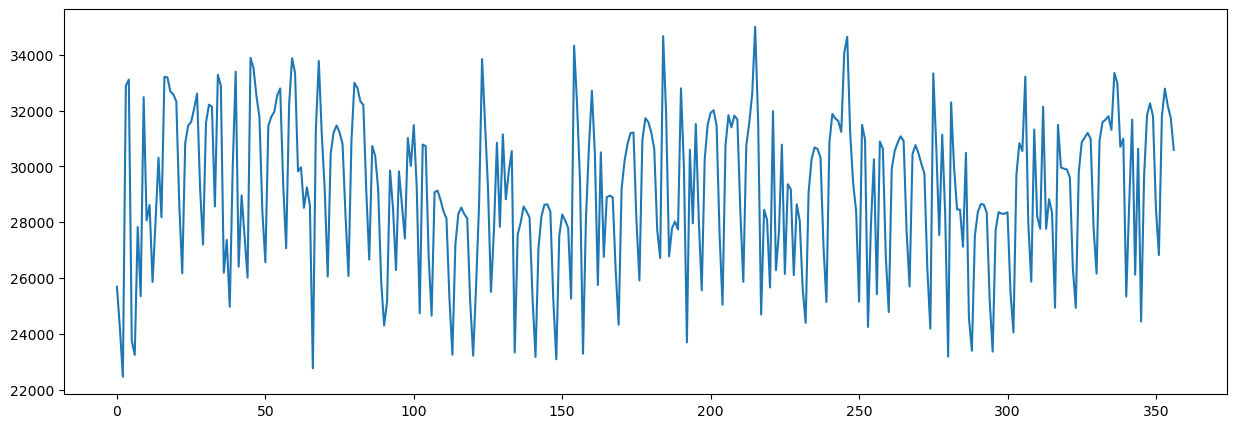

In [ ]:
plt.plot(Y_true_sarima[:len(final_predictions)])

In [ ]:
df_final

y_true        Y_pred
datetime                              
2017-12-30  25689.041667  25689.035143
2017-12-31  24203.541667  24203.534537
2018-01-01  22462.000000  22461.989082
2018-01-02  32893.458333  32893.456538
2018-01-03  33111.458333  33111.458125
...                  ...           ...
2018-12-17  31781.250000  31781.245212
2018-12-18  32787.125000  32787.119879
2018-12-19  32167.416667  32167.411971
2018-12-20  31731.041667  31731.036683
2018-12-21  30594.333333  30594.327741

[357 rows x 2 columns]